In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1b_5KN7e6nvyOdHIt3_YWuYbG3xYeIrjp
!gdown --id 1YgMblFuaMBxXuJoNT9KXj411l9RdAWmG

In [ ]:
!pip install --upgrade sklearn
!pip install --upgrade statsmodels
!pip install tsfresh
!pip install prophet

 # Dependencies

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, PowerTransformer

In [ ]:
from prophet import Prophet
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from itertools import product


import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

import missingno as msno

In [ ]:
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
from scipy.fft import rfft, rfftfreq
from scipy.fft import irfft

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

In [ ]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import roll_time_series
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

# Support

In [ ]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
def pipeline(cont_vars, ordinal_vars):

    pipeline_cont = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, cont_vars])),
                                ('scaler', StandardScaler())
                                ])
    
    pipeline_ordinal = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, ordinal_vars]))
                              ])
    
    feature_union = FeatureUnion(transformer_list = [
                                                     ("pipeline_cont", pipeline_cont),
                                                     ("pipeline_ordinal", pipeline_ordinal)
                                                    ]
                                 )
    
    union = Pipeline(steps = [
                                  ('feature_processing', feature_union)
                                  ]
                                 )
    return union

In [ ]:
def dist_graph(data, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    alpha = 1e-3
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")
    if p < alpha:  # 
        print("The null hypothesis can be rejected")
        print("Oops, We shoukd try to transform the distribution!")
    else:
        print("The null hypothesis cannot be rejected")
        return data.loc[:, target_col], 1

    if p < alpha:
        data.loc[:, target_col+'_box'], lmbda = stats.boxcox(data.loc[:, target_col])
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(data.loc[:, target_col+'_box'], fit=norm, ax=axes[0]);
        res = stats.probplot(data.loc[:, target_col+'_box'], plot=axes[1])
        plt.tight_layout()
        plt.show()

        #skewness and kurtosis
        print("Skewness: %f" % data.loc[:, target_col+'_box'].skew())
        print("Kurtosis: %f" % data.loc[:, target_col+'_box'].kurt(), "\n")

        k2, p = stats.normaltest(data.loc[:, target_col+'_box'])
        alpha = 1e-3
        print("null hypothesis: x comes from a normal distribution")
        print(f"p_value = {p}, {k2}")
        if p < alpha:  # 
            print("The null hypothesis still can be rejected")
            print("But we did our best")
        else:
            print("The null hypothesis cannot be rejected now")
    return data.loc[:, target_col+'_box'], lmbda

In [ ]:
def decomposition_graph(fitted_model, y_data):

    trend = pd.DataFrame(index=y_data.index, columns = ["trend"], data=fitted_model.trend)
    seasonal = pd.DataFrame(index=y_data.index, columns =["seasonal"], data=fitted_model.seasonal)
    resid = pd.DataFrame(index=y_data.index, columns = ["resid"], data=fitted_model.resid)

    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(15,12))

    y_data.loc[:"2011-02-28"].plot(ax=ax1)
    trend.loc[:"2011-02-28"].plot(ax=ax1)
    
    ax2.plot(seasonal.loc[:"2011-02-28"].index, seasonal.mean()[0]*np.ones(len(seasonal.loc[:"2011-02-28"])), "y",
            label=f"mean = {seasonal.mean()[0]:.3g}")    
    seasonal.loc[:"2011-02-28"].plot(color = "black", ax=ax2)

    
    ax2.legend()

    resid.loc[:"2011-02-28"].plot(ax=ax3)

    durbinWatson = durbin_watson(resid.dropna())
    ax1.set_title("Trend")
    ax2.set_title("Seasonal")
    ax3.set_title("Resid, "+ f"DurbinWatson coef for resids = {durbinWatson[0]:0.03}")
    plt.tight_layout()
    plt.legend()
    plt.show()
    return trend, seasonal, resid

In [ ]:
def resid_analysis(resid):
    x_fit = np.linspace(resid.min(), resid.max(), len(resid))
    loc_laplace, scale_laplace = stats.laplace.fit(resid)
    loc_norm, scale_norm = norm.fit(resid)
    print(f"Fitting of residuals by Laplace distribution: fitted mean = {loc_laplace:.3f}, fitted std = {scale_laplace:.3f}")
    print(f"Fitting of residuals by Normal distribution: fitted mean = {loc_norm:.3f}, fitted std = {scale_norm:.3f}")
    y_fit_laplace = stats.laplace.pdf(x_fit, loc_laplace, scale_laplace)
    y_fit_norm = stats.norm.pdf(x_fit, loc_norm, scale_norm)

    plt.subplots(1, 2, figsize=(25, 5))

    plt.subplot(1, 2, 1)
    plt.plot(resid, '-')
    plt.grid(linestyle=':', color='k')
    plt.title("Residuals")

    plt.subplot(1, 2, 2)
    sns.distplot(resid, bins=100, vertical=True, label="distribution of residuals")
    plt.plot(y_fit_laplace, x_fit, '-b', 
            label=f"approximation by Laplace distribution:\n  fitted mean = {loc_laplace:.4g}, fitted std = {scale_laplace:.4g}")
    plt.plot(y_fit_norm, x_fit, '-g', 
            label=f"approximation by normal distribution:\n  fitted mean = {loc_norm:.4g}, fitted std = {scale_norm:.4g}")
    plt.legend()
    # plt.ylim(resid-0.02*y_range, y_max+0.02*y_range)
    plt.title("Distribution of residuals")
    plt.grid(linestyle=':', color='k')

    plt.tight_layout()
    plt.show()

In [ ]:
def count_nan_inarow(series):
    dict_ = {}
    previous_is_na = False
    i = 0
    for element in series.replace(np.nan, "NaN"):
        if element == "NaN":
            if previous_is_na:
                dict_[i] -= 1
                i += 1
                if dict_.get(i, "ups") == "ups":
                    dict_[i] = 1
                else:
                    dict_[i] += 1
            else:
                i += 1
                if dict_.get(i, "ups") == "ups":
                    dict_[i] = 1
                else:
                    dict_[i] += 1
                previous_is_na = True
        else:
            previous_is_na = False
            i = 0
    dict_ = {k: v for k, v in dict_.items() if v != 0}
    print("We've got:")
    [print(f"{v} cases with {k} missing values in a row") for k, v in dict_.items()]
    pass

In [ ]:
def stationarity_tests(series):
    alpha = 0.05
    print(f"alpha = {alpha}\n")

    # ADF Test
    print("Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): ")
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < alpha:
        print("The process is stationary.\n")
    else:
        print("The process is non-stationary.\n")  

    # kpss test
    print('Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):')
    kpsstest = kpss(series, regression='c')
    print("KPSS Statistic = " + str(kpsstest[0]))
    print( "p-value = " +str(kpsstest[1]))
    if kpsstest[1] < alpha:
        print("The process is non-stationary.\n")
    else:
        print("The process is stationary.\n")

# Data Loading

In [ ]:
y_data = pd.read_csv("/content/hour.csv")
y_data = y_data.loc[:, ["dteday", "hr", "cnt"]]
y_data["dteday"] = pd.to_datetime(y_data["dteday"])
y_data['dteday'] +=  pd.to_timedelta(y_data["hr"], unit='h')
y_data.set_index("dteday", inplace=True)
y_data.drop(columns=["hr"], inplace=True)
y_data.sort_index(inplace=True)

dates_list = pd.date_range(start=y_data.index[0], end=y_data.index[-1], freq="H")
dates_adj = pd.DataFrame(index=dates_list)
y_data = pd.merge(dates_adj, y_data, how="left", left_index=True, right_index=True)

In [ ]:
y_train, y_test = y_data.loc[:"2012-11-30"], y_data.loc["2012-11-30":]

transformer = PowerTransformer(method='yeo-johnson', standardize=True)
y_train_tr = transformer.fit_transform(y_train.dropna())
y_test_tr = transformer.transform(y_test.dropna())

# Preparation of exogenous data

Advanced regression task EDA: https://colab.research.google.com/drive/1-qpTld2DOD_Mdp05H8A5t5DV67L608OI?usp=sharing

In [ ]:
data = pd.read_csv("hour.csv", index_col="instant")
data.loc[:, "dteday"] = pd.to_datetime(data.loc[:, "dteday"])
data.loc[:, 'dteday'] +=  pd.to_timedelta(data["hr"], unit='h')
data = data.set_index("dteday")

data.drop(columns=["yr"], inplace=True)
data.drop(columns=["weekday", "season"], inplace=True)

Сategories = ["holiday", "workingday", "weathersit"]
for var in Сategories:
    data.loc[:, var] = data.loc[:, var].astype("category")

x_data = data.drop(columns=['casual', 'registered', 'cnt'])

# We will create 3 groups: first(0), second(1), third(2)
bin_first = [1, 2, 12]
bin_second = [4, 11]
bin_third = [5, 6, 7, 8, 9, 10]

x_data.loc[:, 'mnth_group'] = 0
x_data.loc[x_data["mnth"].isin(bin_second), 'mnth_group'] = 1
x_data.loc[x_data["mnth"].isin(bin_third), 'mnth_group'] = 2

x_data.drop(columns=["mnth"], inplace=True)

# We will create 4 degree: first(0), second(1), third(2), fourth(3)
bin_first = [0, 1, 2, 3, 4, 5]
bin_second = [6, 22, 23]
bin_third = [7, 9, 10, 11, 12, 13, 14, 15, 20, 21]
bin_fourth = [8, 16, 17, 18, 19]

x_data.loc[:, 'degree'] = 0
x_data.loc[x_data["hr"].isin(bin_second), 'degree'] = 1
x_data.loc[x_data["hr"].isin(bin_third), 'degree'] = 2
x_data.loc[x_data["hr"].isin(bin_fourth), 'degree'] = 3

x_data.drop(columns=["hr"], inplace=True)

x_train, x_test = x_data.loc[:"2012-11-30"], x_data.loc["2012-11-30":]

x_train_1, x_test_1 = x_data.loc[:"2012-11-30"], x_data.loc["2012-11-30":]

In [ ]:
# cont. vars pipeline: StandardScaler
cont_var = ['atemp', 'hum', 'windspeed']

# ordinal vars pipeline: already encoded
ordinal_var= ['holiday', 'workingday', 'weathersit', 'mnth_group', 'degree']

In [ ]:
pipeline_ = pipeline(cont_var, ordinal_var)
x_train = pipeline_.fit_transform(x_train)
x_test = pipeline_.transform(x_test)

# Models with exo-features only

## Model fitting

In [ ]:
lgbm = LGBMRegressor(random_state=42, min_child_samples=20, 
                     n_estimators=350, num_leaves=10, reg_alpha=0.5, 
                     reg_lambda=1.2)
linear = LinearRegression()

lgbm.fit(x_train, y_train_tr)
linear.fit(x_train, y_train_tr)

lgbm_predictions_train = transformer.inverse_transform(lgbm.predict(x_train).reshape(-1,1))
lgbm_predictions_test = transformer.inverse_transform(lgbm.predict(x_test).reshape(-1,1))

linear_predictions_train = transformer.inverse_transform(linear.predict(x_train).reshape(-1,1))
linear_predictions_test = transformer.inverse_transform(linear.predict(x_test).reshape(-1,1))

In [ ]:
# r2
r2_score_train = np.round(r2_score(y_train.dropna(), linear_predictions_train), 4)
r2_score_test = np.round(r2_score(y_test.dropna(), linear_predictions_test), 4)
# mae
mae_train = np.round(mean_absolute_error(y_train.dropna(), linear_predictions_train), 4)
mae_test = np.round(mean_absolute_error(y_test.dropna(), linear_predictions_test), 4)

print("exo-linear quality:")
print(f"r2 score train: {r2_score_train}, r2 score test {r2_score_test}")
print(f"mae train: {mae_train}, mae test {mae_test}")

exo-linear quality:
r2 score train: 0.5948, r2 score test 0.3324
mae train: 76.7177, mae test 90.2462


In [ ]:
# r2
r2_score_train = np.round(r2_score(y_train.dropna(), lgbm_predictions_train), 4)
r2_score_test = np.round(r2_score(y_test.dropna(), lgbm_predictions_test), 4)
# mae
mae_train = np.round(mean_absolute_error(y_train.dropna(), lgbm_predictions_train), 4)
mae_test = np.round(mean_absolute_error(y_test.dropna(), lgbm_predictions_test), 4)

print("exo-lgbm quality:")
print(f"r2 score train: {r2_score_train}, r2 score test {r2_score_test}")
print(f"mae train: {mae_train}, mae test {mae_test}")

exo-lgbm quality:
r2 score train: 0.7574, r2 score test 0.4402
mae train: 59.1858, mae test 78.611


In [ ]:
resid_table = y_test.dropna()
resid_table.loc[:, ["test"]] = lgbm_predictions_test

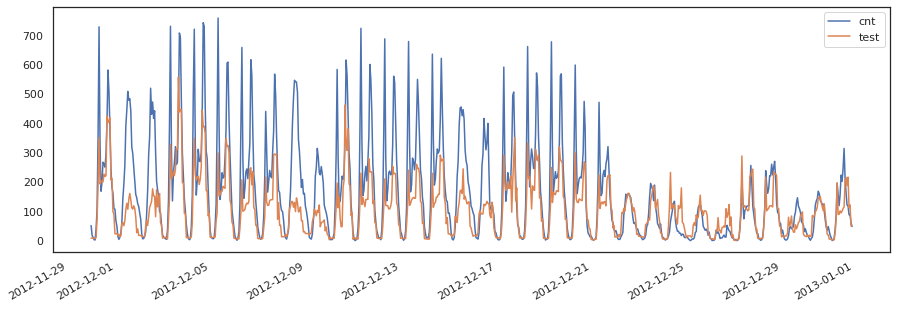

In [ ]:
resid_table.loc[:, ["cnt", "test"]].plot(figsize=(15, 5))
plt.show()

## Residual analysis

In [ ]:
resid_table["resids"] = resid_table["cnt"] - resid_table["test"]

Fitting of residuals by Laplace distribution: fitted mean = 26.192, fitted std = 74.316
Fitting of residuals by Normal distribution: fitted mean = 63.206, fitted std = 106.878


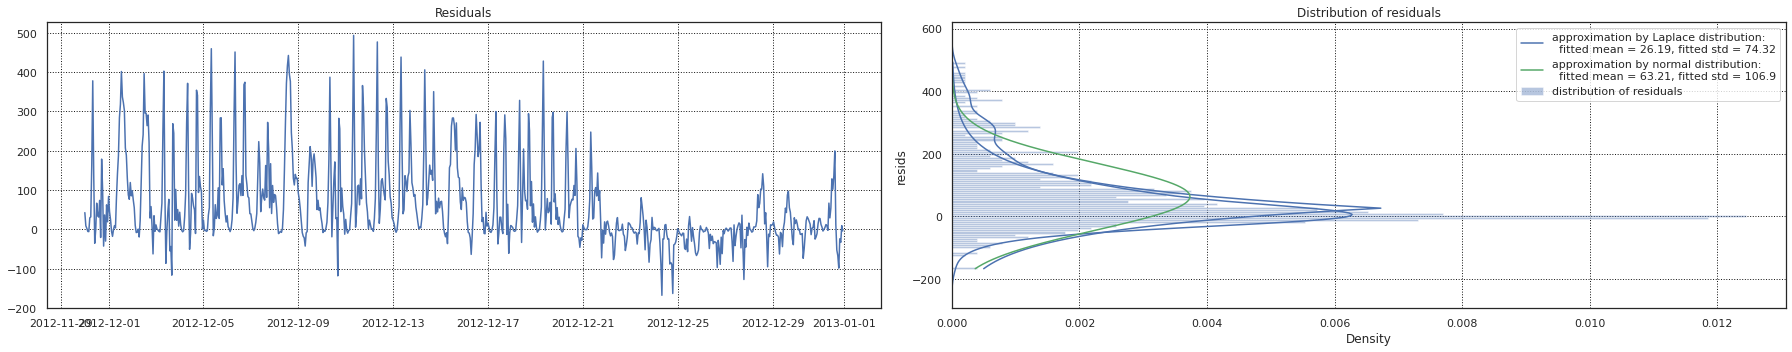

In [ ]:
resid_analysis(resid_table["resids"])

The distribution of errors is highly skewed, the model clearly underestimates the predictions. A complete description of the problem you can find in my advanced regression file, where I detail analyzed the results of that model.

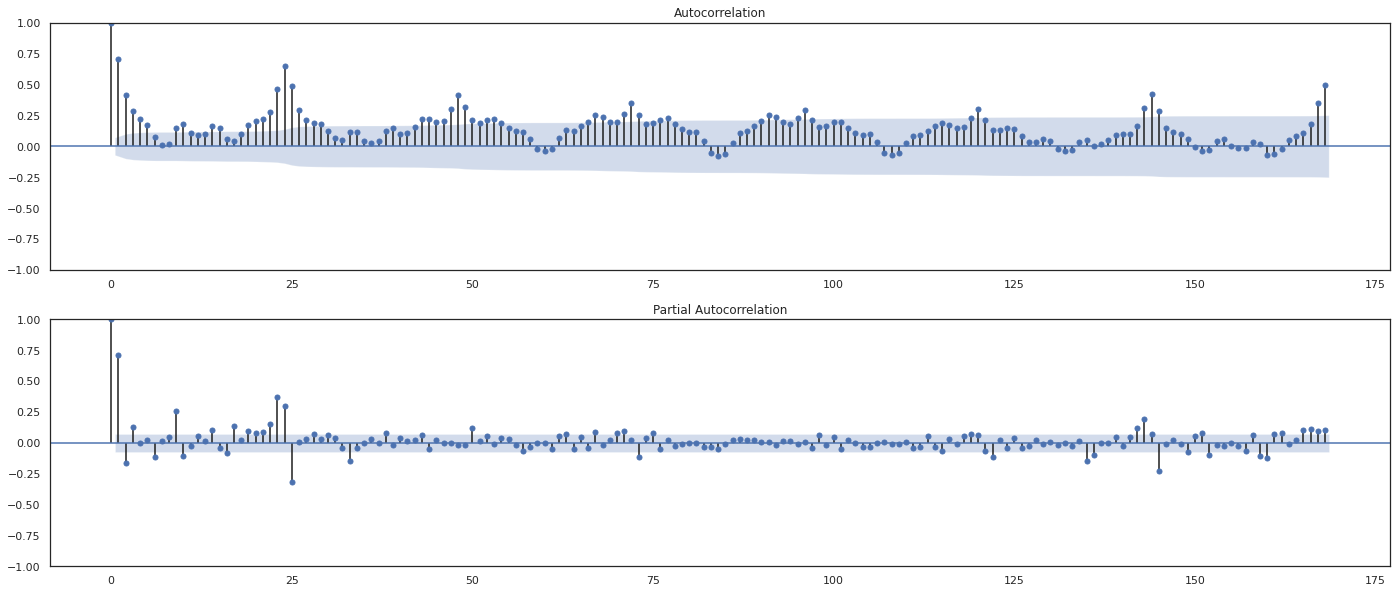

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid_table["resids"].values.squeeze(), lags=24*7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid_table["resids"].values.squeeze(), lags=24*7, ax=ax2)

Here we can check ACF and PACF plots of model's residuals. There is a pattern in the ACF plot, which means we can extract more information from data and make our model more complicated and precise. 

# Baseline. Endog Features only

But before we move forward, let's build some kind of trend model, using only indexes of our observations. Maybe it will be more meaningful to add here also some time-based features, but for now, it's not really necessary, so let's check only the trend component of the  data

##Model fitting

In [ ]:
import datetime
y_train_x = np.array(pd.to_datetime(y_train.dropna().index).map(datetime.datetime.toordinal)).reshape(-1, 1)
y_test_x = np.array(pd.to_datetime(y_test.dropna().index).map(datetime.datetime.toordinal)).reshape(-1, 1)

In [ ]:
baseline_model = LinearRegression(normalize=True)
baseline_model.fit(y_train_x, y_train_tr)

train_predict_trend = transformer.inverse_transform(baseline_model.predict(y_train_x).reshape(-1,1))
test_predict_trend = transformer.inverse_transform(baseline_model.predict(y_test_x).reshape(-1,1))

In [ ]:
# r2
r2_score_train = np.round(r2_score(y_train.dropna(), train_predict_trend), 4)
r2_score_test = np.round(r2_score(y_test.dropna(), test_predict_trend), 4)
# mae
mae_train = np.round(mean_absolute_error(y_train.dropna(), train_predict_trend), 4)
mae_test = np.round(mean_absolute_error(y_test.dropna(), test_predict_trend), 4)

print("simple trend quality:")
print(f"r2 score train: {r2_score_train}, r2 score test {r2_score_test}")
print(f"mae train: {mae_train}, mae test {mae_test}")

simple trend quality:
r2 score train: -0.0181, r2 score test -0.0968
mae train: 132.7216, mae test 145.7899


In [ ]:
y_train["model"] = train_predict_trend
y_test["model"] = test_predict_trend

y_test["resids"] = y_test["model"] - y_test["cnt"]

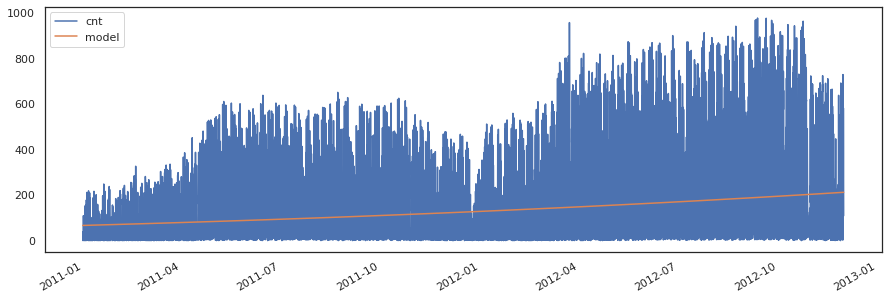

In [ ]:
y_train.loc[:, ["cnt", "model"]].plot(figsize=(15, 5))
plt.show()

We see that there is a clear trend in our time series. Maybe it is one of those factors why the previous model underestimates the predictions

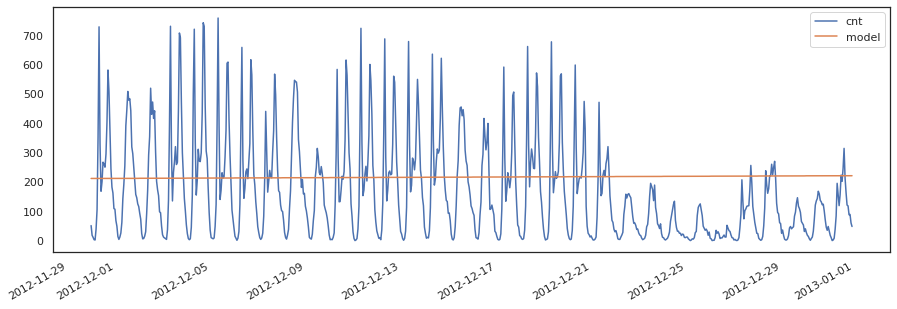

In [ ]:
y_test.loc[:, ["cnt", "model"]].plot(figsize=(15, 5))
plt.show()

## Residual analysis

Fitting of residuals by Laplace distribution: fitted mean = 97.459, fitted std = 127.397
Fitting of residuals by Normal distribution: fitted mean = 48.306, fitted std = 166.959


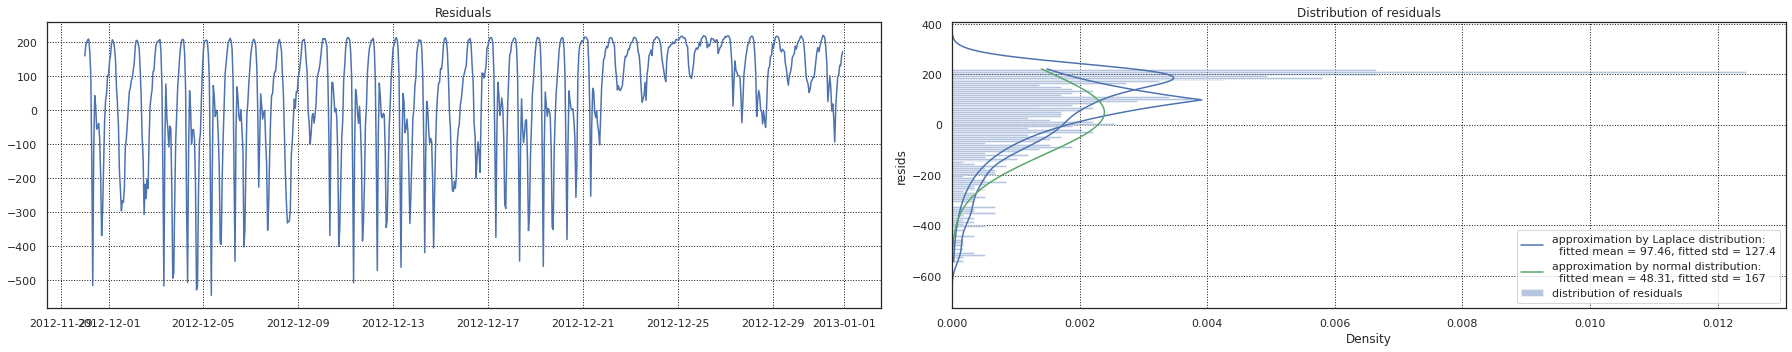

In [ ]:
resid_analysis(y_test["resids"])

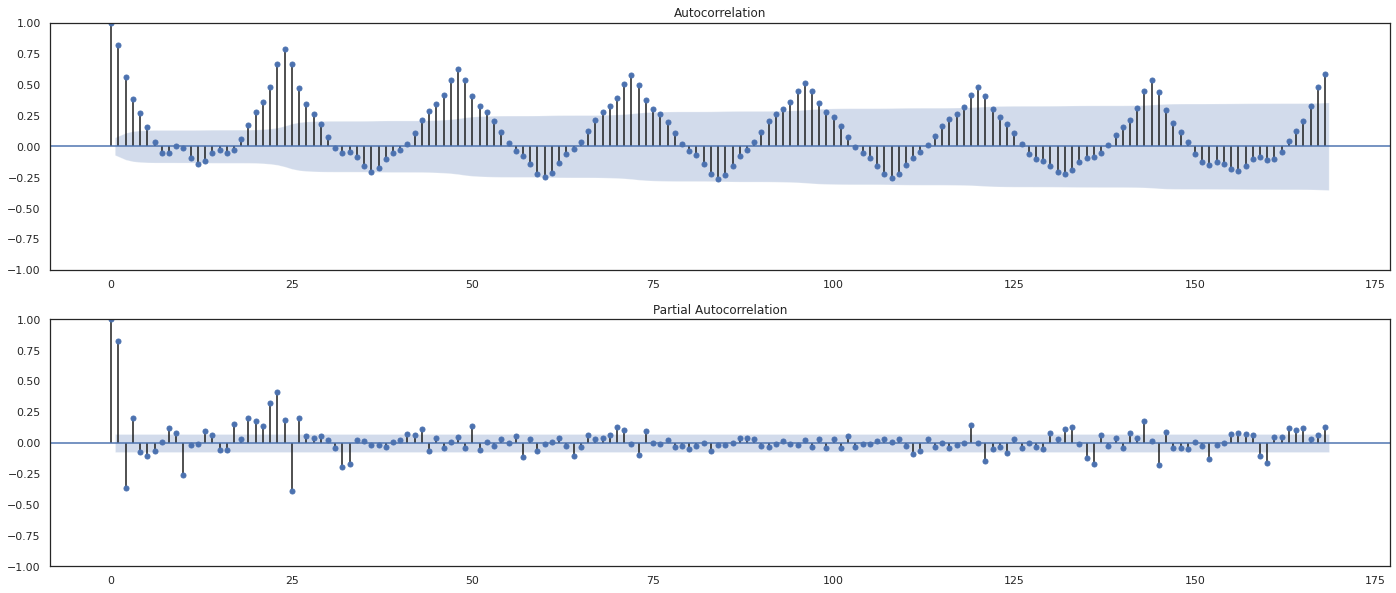

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_test["resids"].values.squeeze(), lags=24*7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_test["resids"].values.squeeze(), lags=24*7, ax=ax2)

And it's pretty apparent that except for the trend component we've got here also seasonal components

# Exo-Features + Endo by TSFresh

Now we can try to unite exogen features and endogen features to create a more powerful model. Here I will use the TSFresh library to extract some endogen features from the series.

## Model fitting

In [ ]:
new_y = y_data.reset_index()
new_y["cnt"] = (new_y.interpolate(limit_direction='forward').loc[:, "cnt"] + new_y.interpolate(limit_direction='backward').loc[:, "cnt"])/2
new_y["cnt"] = transformer.transform(new_y[["cnt"]])
new_y.columns = ["time", "value"]
new_y["id"] = "a"

In [ ]:
data_rolled = roll_time_series(df_or_dict=new_y, column_id="id", column_sort="time", max_timeshift=5, min_timeshift=4)

Rolling: 100%|██████████| 5/5 [01:12<00:00, 14.49s/it]


In [ ]:
data_rolled.head()

time     value                        id
0 2011-01-01 00:00:00 -1.238440  (a, 2011-01-01 04:00:00)
1 2011-01-01 01:00:00 -0.778039  (a, 2011-01-01 04:00:00)
2 2011-01-01 02:00:00 -0.902736  (a, 2011-01-01 04:00:00)
3 2011-01-01 03:00:00 -1.325059  (a, 2011-01-01 04:00:00)
4 2011-01-01 04:00:00 -1.969385  (a, 2011-01-01 04:00:00)

In [ ]:
# lets extract just a minimal set of features, because it's time consuming operation
x_extr = extract_features(data_rolled, column_id="id", column_sort="time", 
                          default_fc_parameters=settings.MinimalFCParameters(),
                          impute_function=impute)

x_extr.reset_index(inplace=True)
x_extr.drop(columns=["level_0"], inplace=True)
x_extr.set_index("level_1", inplace=True)

# tsfresh could select features, but we have extracted not so many of them, so there is no need for that operation
# matrix_x = select_features(x_extr, y_data.loc[4:, "value"].values)

Feature Extraction: 100%|██████████| 5/5 [00:17<00:00,  3.54s/it]


In [ ]:
x_extr.head()

value__sum_values  ...  value__minimum
level_1                                 ...                
2011-01-01 04:00:00          -6.213659  ...       -1.969385
2011-01-01 05:00:00          -8.183044  ...       -1.969385
2011-01-01 06:00:00          -8.808044  ...       -1.969385
2011-01-01 07:00:00          -9.810325  ...       -1.969385
2011-01-01 08:00:00         -10.412445  ...       -1.969385

[5 rows x 9 columns]

In [ ]:
matrix_x_train, matrix_x_test = x_extr.loc[:"2012-11-30"], x_extr.loc["2012-11-30":]
columns_list = matrix_x_train.columns.values

matrix_x_train = pd.merge(x_train_1, matrix_x_train, left_index=True, right_index=True, how="left")
matrix_x_test = pd.merge(x_test_1, matrix_x_test, left_index=True, right_index=True, how="left")

matrix_x_train = matrix_x_train.loc[:, columns_list]
matrix_x_test = matrix_x_test.loc[:, columns_list]

matrix_x_train = matrix_x_train.bfill()
matrix_x_test = matrix_x_test.bfill()

x_train = np.hstack([x_train, matrix_x_train.values])
x_test = np.hstack([x_test, matrix_x_test.values])

In [ ]:
lgbm = LGBMRegressor(random_state=42, min_child_samples=20, 
                     n_estimators=350, num_leaves=10, reg_alpha=0.5, 
                     reg_lambda=1.2)

lgbm.fit(x_train, y_train_tr)

lgbm_predictions_train = transformer.inverse_transform(lgbm.predict(x_train).reshape(-1,1))
lgbm_predictions_test = transformer.inverse_transform(lgbm.predict(x_test).reshape(-1,1))

In [ ]:
# r2
r2_score_train = np.round(r2_score(y_train.dropna(), lgbm_predictions_train), 4)
r2_score_test = np.round(r2_score(y_test.dropna(), lgbm_predictions_test), 4)
# mae
mae_train = np.round(mean_absolute_error(y_train.dropna(), lgbm_predictions_train), 4)
mae_test = np.round(mean_absolute_error(y_test.dropna(), lgbm_predictions_test), 4)

print("exo-lgbm quality:")
print(f"r2 score train: {r2_score_train}, r2 score test {r2_score_test}")
print(f"mae train: {mae_train}, mae test {mae_test}")

exo-lgbm quality:
r2 score train: 0.9586, r2 score test 0.9205
mae train: 22.1666, mae test 27.8518


With such good quality, we can only forecast 1 hour ahead

## Residual analysis

In [ ]:
resid_table = y_test.dropna()
resid_table.loc[:, ["test"]] = lgbm_predictions_test

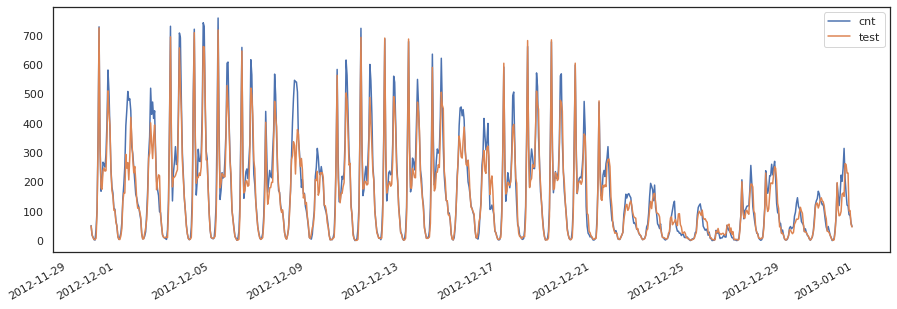

In [ ]:
resid_table.loc[:, ["cnt", "test"]].plot(figsize=(15, 5))
plt.show()

In [ ]:
resid_table["resids"] = resid_table["cnt"] - resid_table["test"]

Fitting of residuals by Laplace distribution: fitted mean = 3.978, fitted std = 27.385
Fitting of residuals by Normal distribution: fitted mean = 14.562, fitted std = 44.464


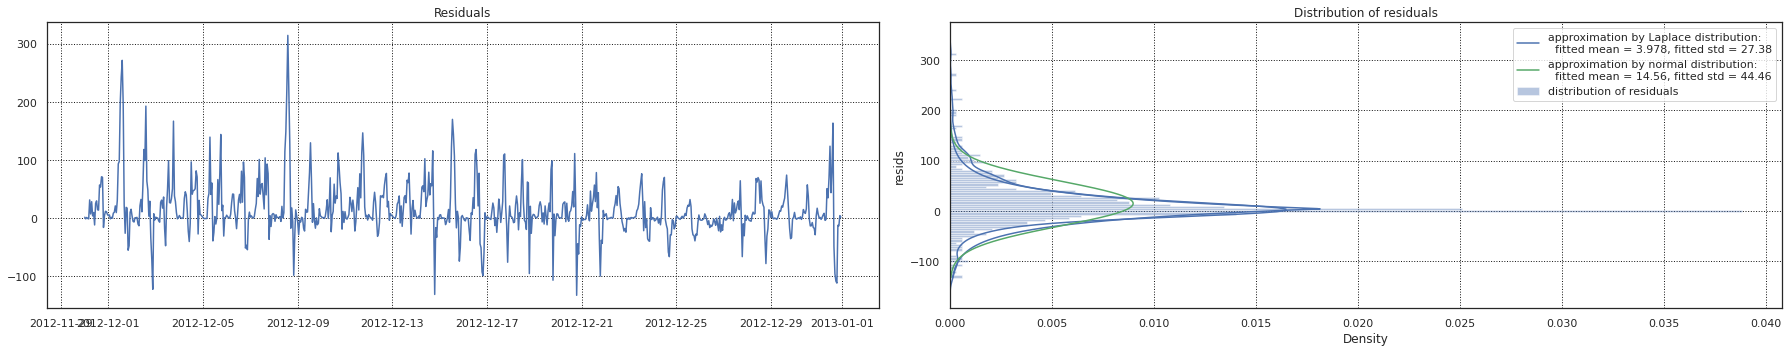

In [ ]:
resid_analysis(resid_table["resids"])

Errors are distributed according to the Laplace distribution. So we better should use MAE for scoring our model.

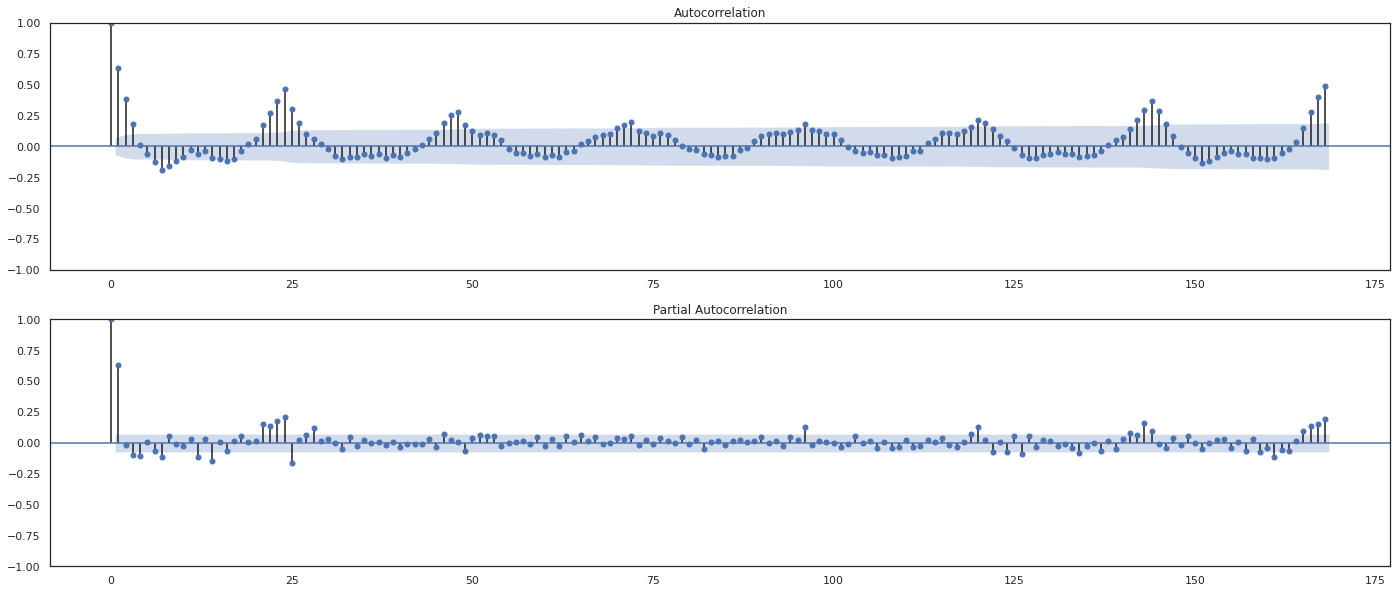

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid_table["resids"].values.squeeze(), lags=24*7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid_table["resids"].values.squeeze(), lags=24*7, ax=ax2)

Despite the fact that model become much vore better, the pattern in errors still exist

# Prophet

Now let's check how the Prophet library works

It's a pretty powerful tool, and we don't have to do any transformations with our data

## Model Fitting

In [ ]:
y_data["cnt"] = (y_data.interpolate(limit_direction='forward').loc[:, "cnt"] + y_data.interpolate(limit_direction='backward').loc[:, "cnt"])/2
y_train, y_test = y_data.loc[:"2012-11-30"], y_data.loc["2012-11-30":]

In [ ]:
y_train['ds'] = y_train.index
y_test['ds'] = y_test.index
y_train.columns = ['y','ds']
y_test.columns = ['y','ds']

In [ ]:
future = pd.date_range(start="2012-11-30 00:00:00", end="2012-12-31 22:00:00", freq="H")
future = pd.DataFrame(future)
future.columns = ['ds']
future.set_index("ds", inplace=True)

We should specify which kind of seasonal components the series has. Also, we can set other parameters, like weekends and so on, but it is not necessary.

In [ ]:
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True)
model.fit(y_train)
forecast = model.predict(future.reset_index())

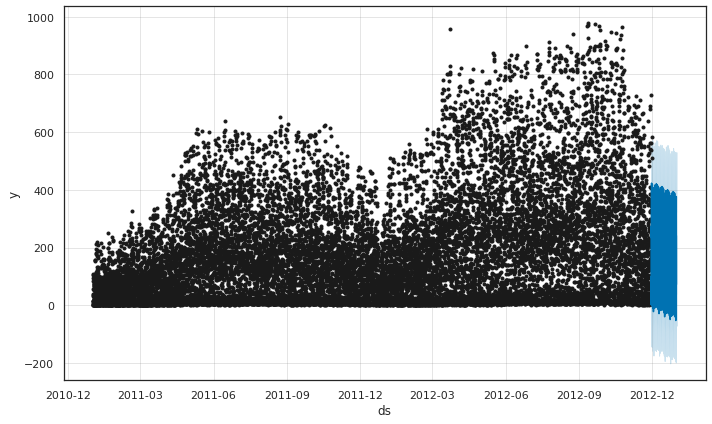

In [ ]:
fig = model.plot(forecast)

In [ ]:
# r2
r2_score_test = np.round(r2_score(y_test["y"], forecast["yhat"]), 4)
# mae
mae_test = np.round(mean_absolute_error(y_test["y"], forecast["yhat"]), 4)

print("Prophet quality:")
print(f"r2 score test {r2_score_test}")
print(f"mae test {mae_test}")

exo-lgbm quality:
r2 score test 0.4487
mae test 85.2419


In [ ]:
forecast.set_index("ds", inplace=True)
y_test.loc[:, ["model"]] = forecast["yhat"]
y_test["resids"] = y_test["model"] - y_test["y"]

## Residual Analysis

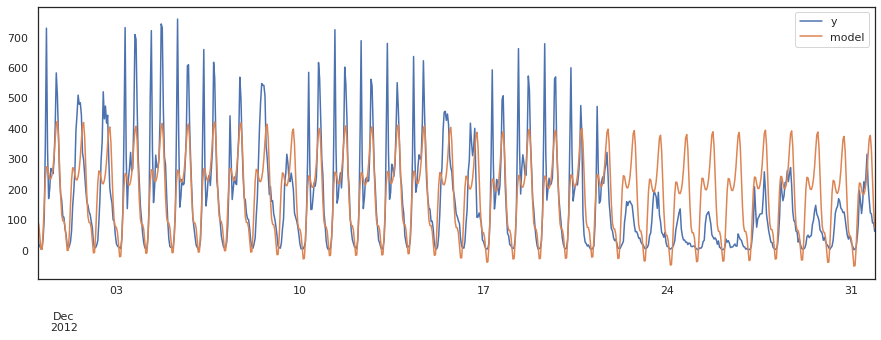

In [ ]:
y_test.loc[:, ["y", "model"]].plot(figsize=(15, 5))
plt.show()

Predictions are pretty good, but it seems like it didn't catch intra-week seasonality

Fitting of residuals by Laplace distribution: fitted mean = 15.293, fitted std = 84.076
Fitting of residuals by Normal distribution: fitted mean = 15.748, fitted std = 122.254


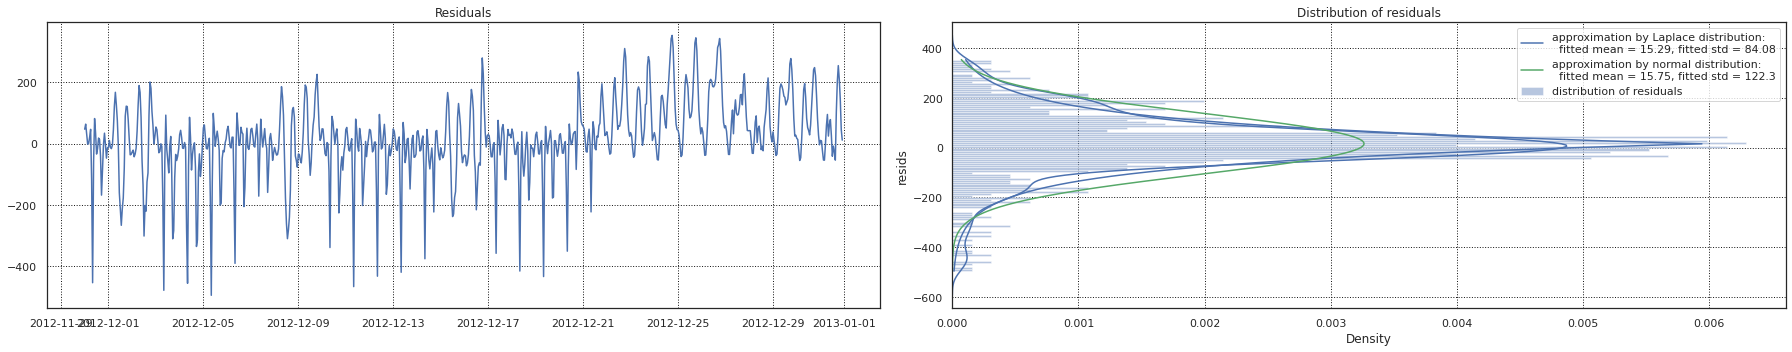

In [ ]:
resid_analysis(y_test["resids"])

The errors are shifted primary because of the New Year holidays

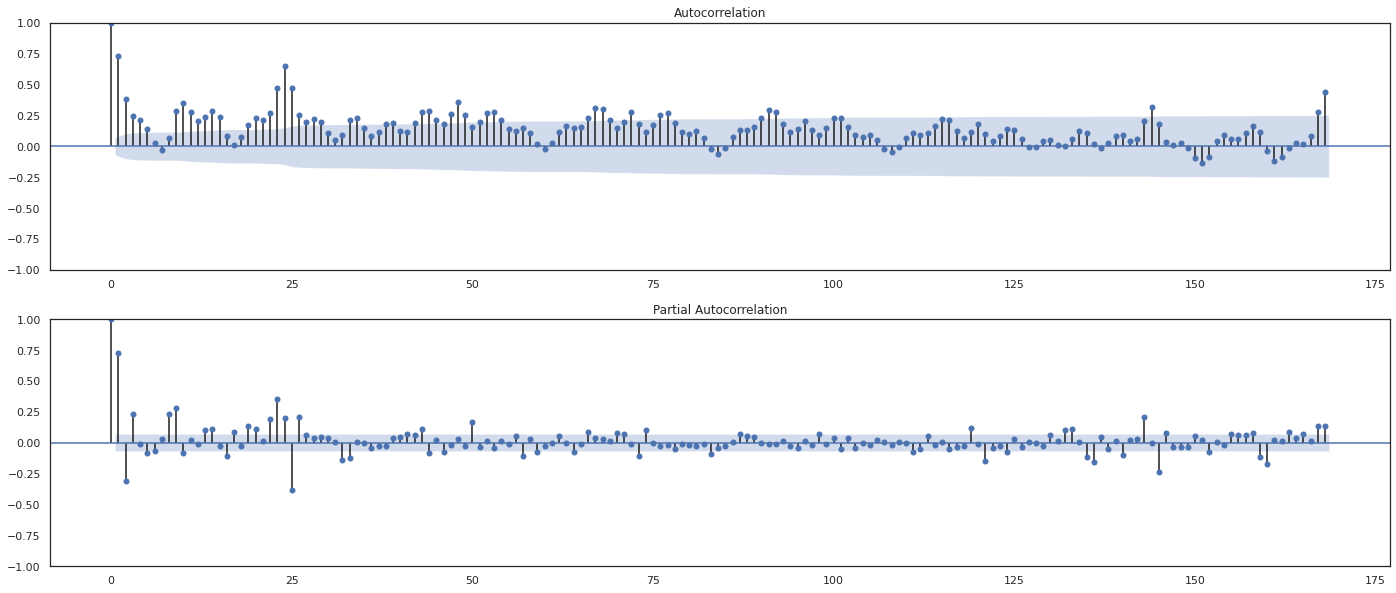

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_test["resids"].values.squeeze(), lags=24*7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_test["resids"].values.squeeze(), lags=24*7, ax=ax2)

Intra-week pattern still exist

# EDA

Okay, now it's time to try to decompose target by ourselves

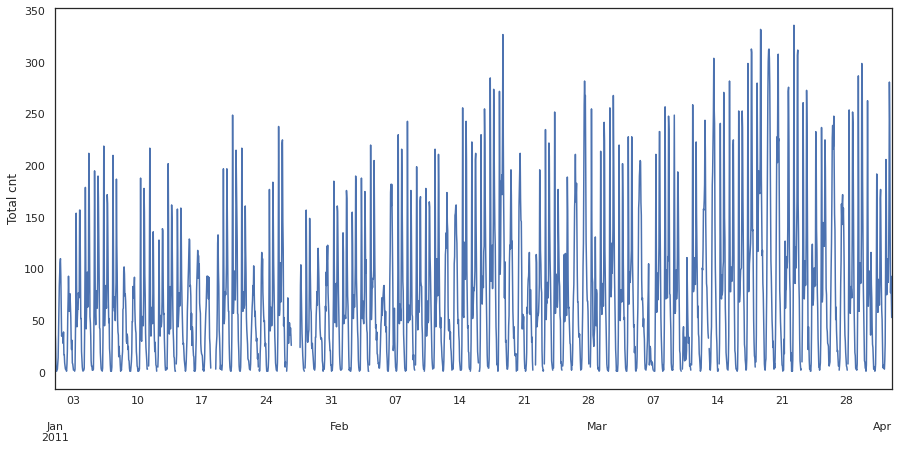

In [ ]:
plt.figure(figsize=(15,7))
y_data.loc[:"2011-04-01", "cnt"].plot()
plt.ylabel(u'Total cnt')
plt.show()

Let's check missing values

In [ ]:
count_nan_inarow(y_data["cnt"])

We've got:
64 cases with 1 missing values in a row
6 cases with 2 missing values in a row
1 cases with 6 missing values in a row
1 cases with 12 missing values in a row
1 cases with 13 missing values in a row
1 cases with 22 missing values in a row
1 cases with 36 missing values in a row


And interpolate them all 

In [ ]:
y_data["cnt"] = (y_data.interpolate(limit_direction='forward').loc[:, "cnt"] + y_data.interpolate(limit_direction='backward').loc[:, "cnt"])/2

In [ ]:
count_nan_inarow(y_data["cnt"])

We've got:


Let's check the time dependence of target for stationarity using two tests - Augmented Dickey–Fuller (ADF) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test.

In [ ]:
stationarity_tests(y_data["cnt"])

alpha = 0.05

Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -6.944056236018263
p-value: 1.0077936418154104e-09
The process is stationary.

Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 19.405038026105295
p-value = 0.01
The process is non-stationary.



Okay, we've got two different results, but it is only statistical criteria; if we will look at our data with eyes, it will be obvious, that our row is far from stationarity

First of all, we have to stabilize the dispersion of the data

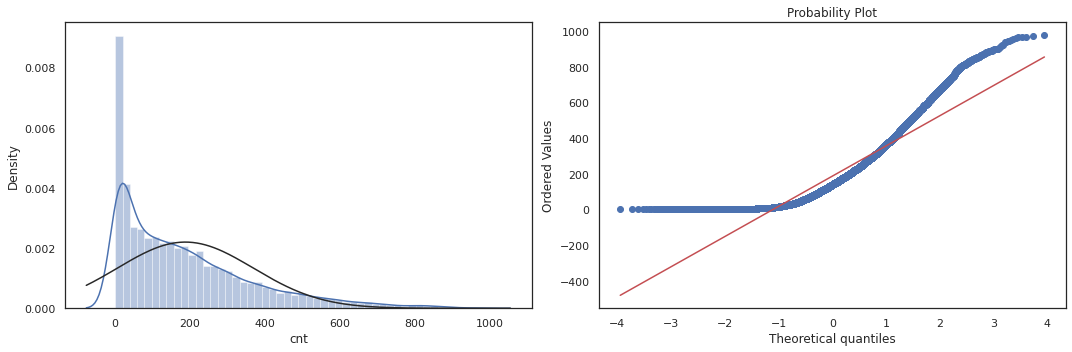

Skewness: 1.285738
Kurtosis: 1.438413 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 3529.16153478848
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


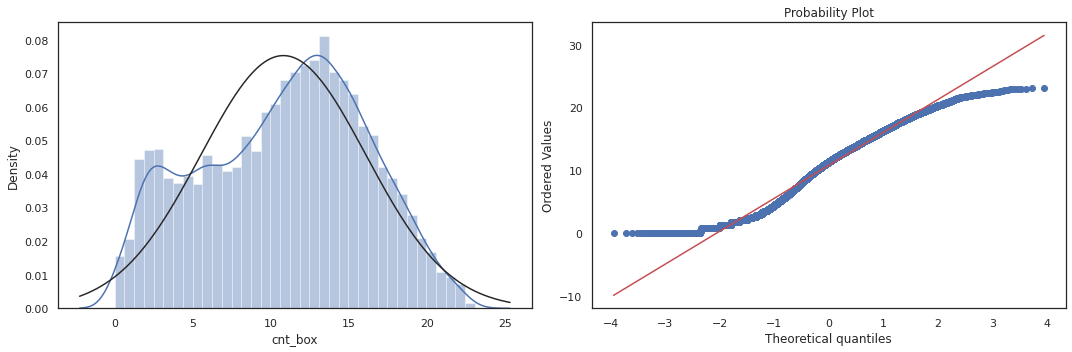

Skewness: -0.149317
Kurtosis: -0.835896 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 1830.9196215487236
The null hypothesis still can be rejected
But we did our best


In [ ]:
y_data.loc[y_data["cnt"] == 0, "cnt"] = 10e-3
y_data.loc[:, 'cnt'], lmbda= dist_graph(y_data.copy(), target_col='cnt')

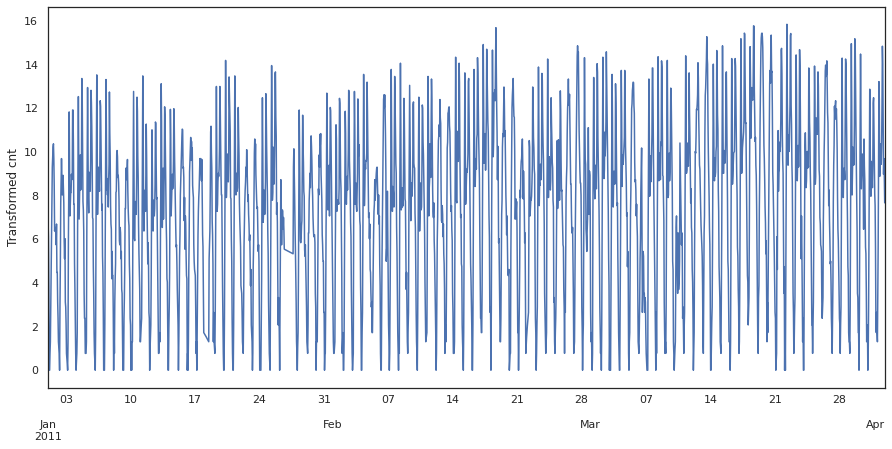

Optimal Box-Cox coef: 0.301286


In [ ]:
plt.figure(figsize=(15,7))
y_data.loc[:"2011-04-01", "cnt"].plot()
plt.ylabel(u'Transformed cnt')
plt.show()
print("Optimal Box-Cox coef: %f" % lmbda)

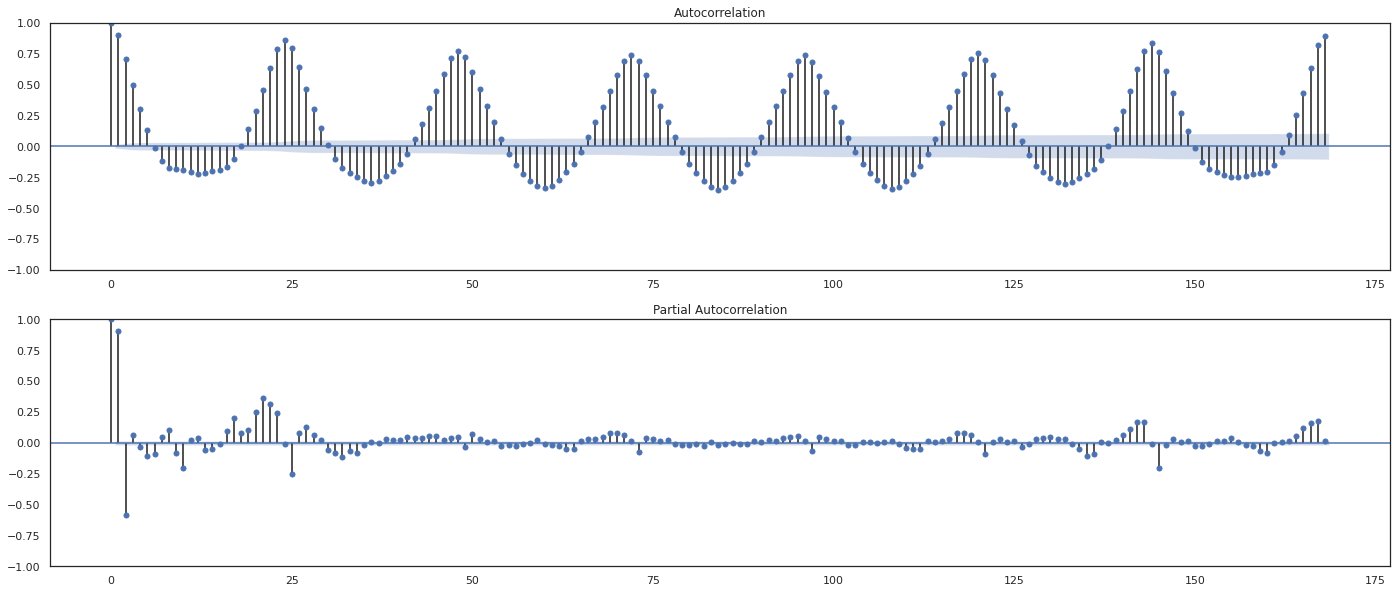

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_data["cnt"].values.squeeze(), lags=24*7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_data["cnt"].values.squeeze(), lags=24*7, ax=ax2)

Here we can see intraday fluctuations

In [ ]:
stationarity_tests(y_data["cnt"])

alpha = 0.05

Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -6.822327908003108
p-value: 1.9873767481621404e-09
The process is stationary.

Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 17.66959067653358
p-value = 0.01
The process is non-stationary.



 # Time Series Decomposition

 let's extract the seasonal components from our data

## First decomposition

We assume that:  
* we have hourly-periodic component
* additive model

In [ ]:
decompose_1 = seasonal_decompose(y_data.values, period=24)

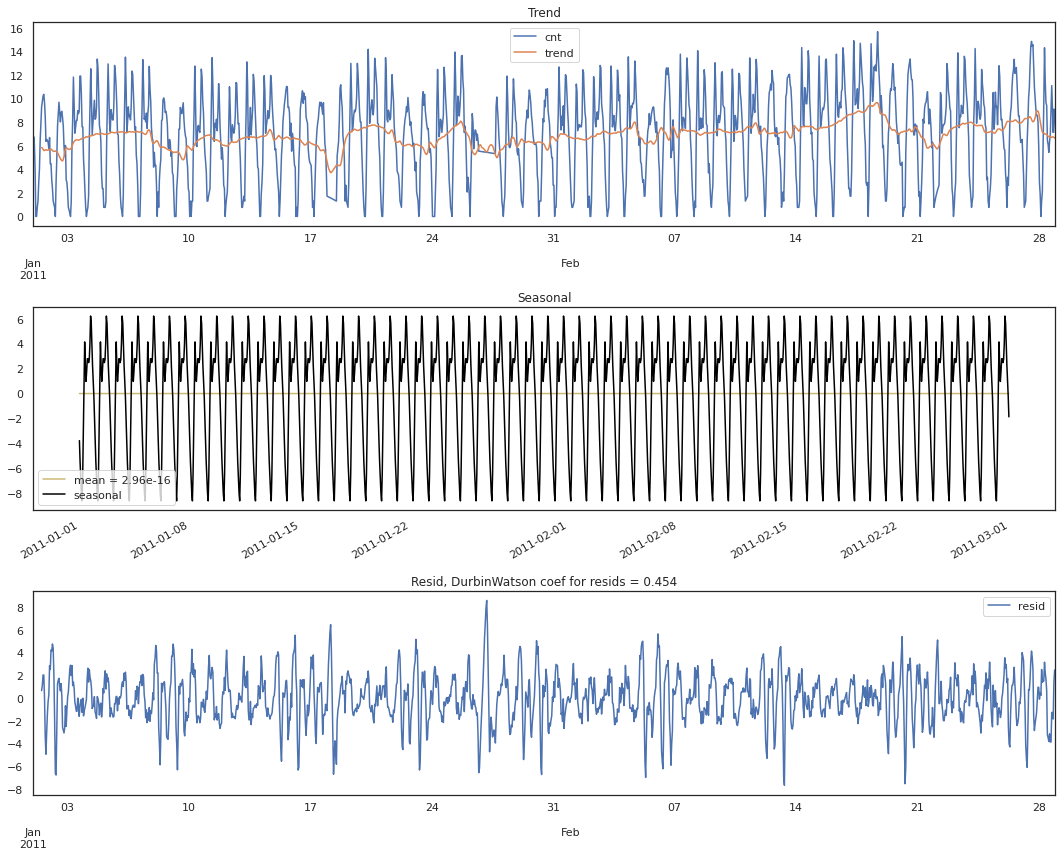

In [ ]:
trend_1, seasonal_1, resid_1 = decomposition_graph(fitted_model=decompose_1, y_data=y_data)

In [ ]:
trend_1.dropna(inplace=True)
seasonal_1.dropna(inplace=True)
resid_1.dropna(inplace=True)

### Residual analysis

Fitting of residuals by Laplace distribution: fitted mean = -0.041, fitted std = 1.722
Fitting of residuals by Normal distribution: fitted mean = 0.000, fitted std = 2.194


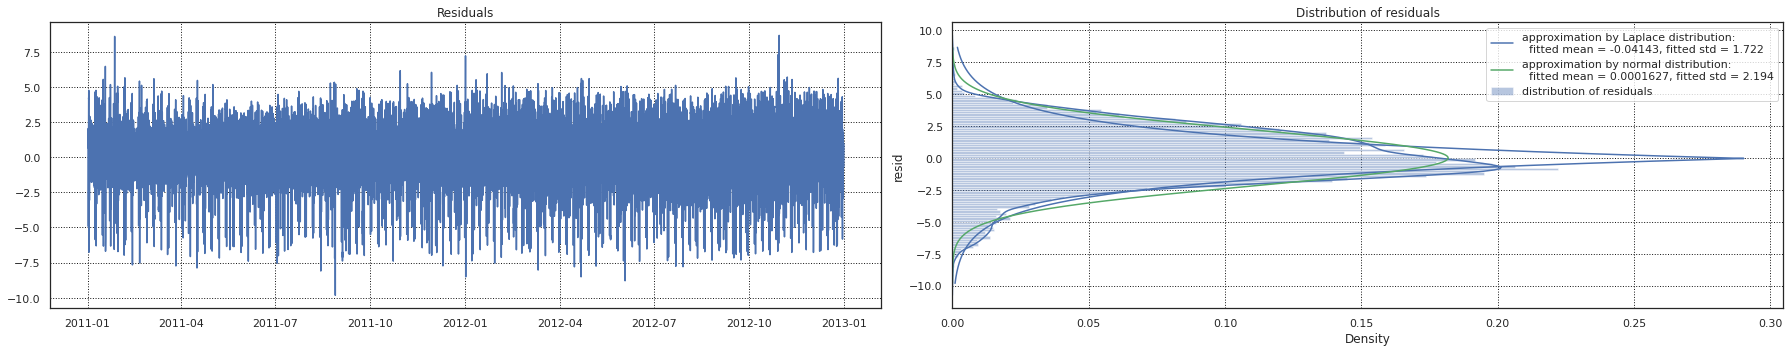

In [ ]:
resid_analysis(resid_1["resid"])

Residuals are quite normal

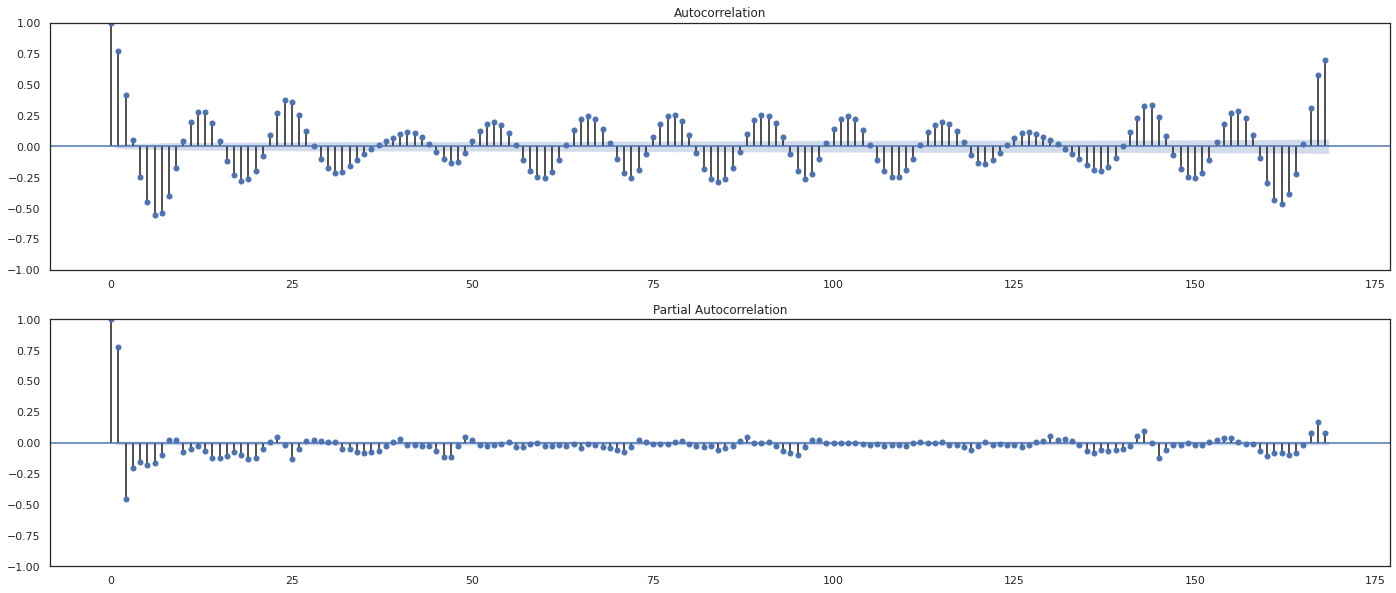

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid_1.values.squeeze(), lags=24*7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid_1.values.squeeze(), lags=24*7, ax=ax2)

Resids contain a seasonal component with a period = 24*7. It means that except for intraday seasonality, we've got a weekly one.

## Second Decomposition

Now we assume that our series contains an additive intra-week seasonality component

In [ ]:
decompose_2 = seasonal_decompose(resid_1.values, period=24*7)

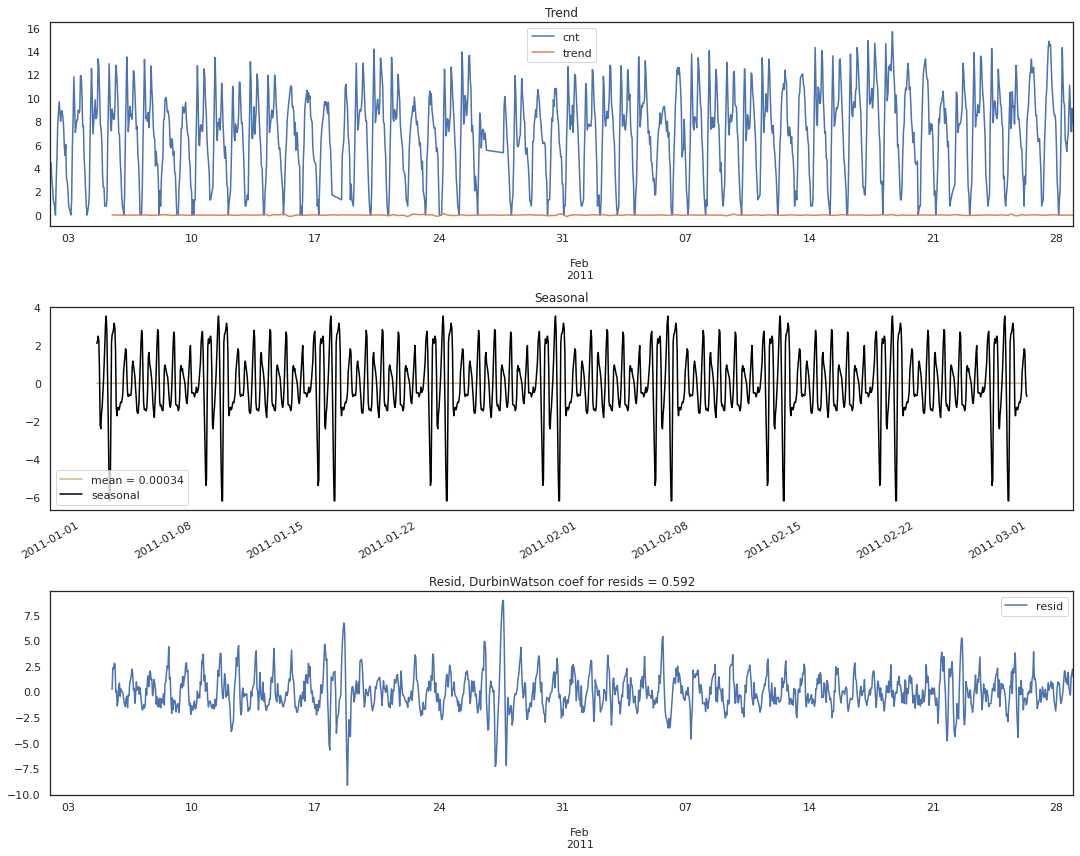

In [ ]:
trend_2, seasonal_2, resid_2 = decomposition_graph(fitted_model=decompose_2, y_data=y_data.iloc[24:])

In [ ]:
trend_2.dropna(inplace=True)
seasonal_2.dropna(inplace=True)
resid_2.dropna(inplace=True)

### Residual analysis

Fitting of residuals by Laplace distribution: fitted mean = 0.000, fitted std = 0.981
Fitting of residuals by Normal distribution: fitted mean = 0.000, fitted std = 1.370


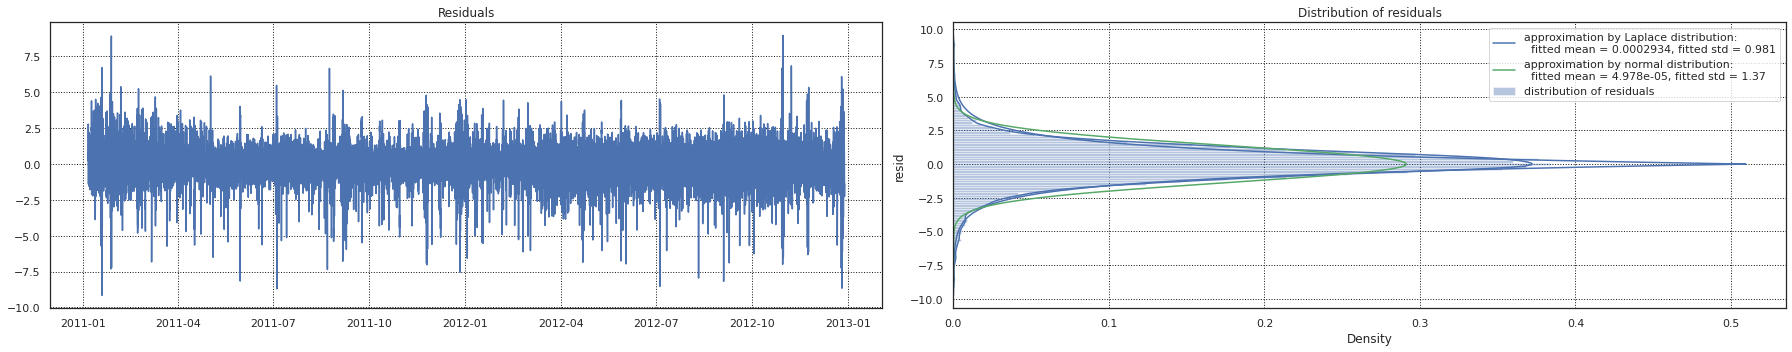

In [ ]:
resid_analysis(resid_2["resid"])

Resids look still good, but distribution switched to Laplace

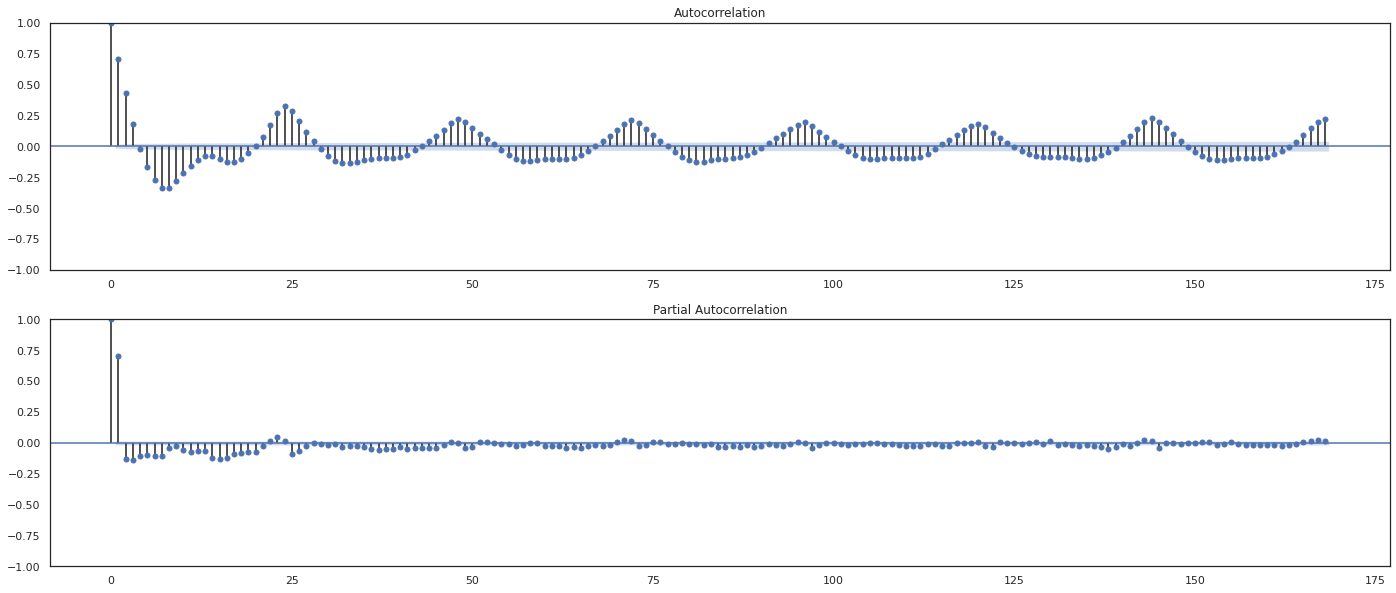

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid_2["resid"].values.squeeze(), lags=24*7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid_2["resid"].values.squeeze(), lags=24*7, ax=ax2)

And we can see one more pattern, I don't really think that the standard approach to decomposition can help here, so let's try to do Fourier decomposition

## Fourier resids decomposition 

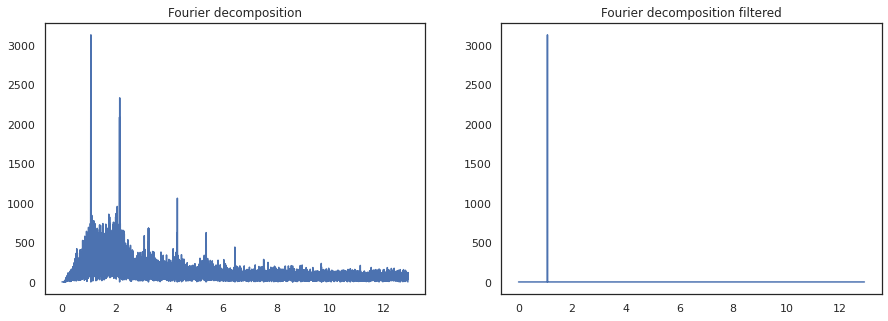

In [ ]:
N = len(resid_2["resid"].values.reshape(1,-1)[0])
DURATION = 2*12*4*7
SAMPLE_RATE = N / DURATION

yf = rfft(resid_2["resid"].values.reshape(1,-1)[0])
yf = np.abs(yf)
xf = rfftfreq(N, 1 / SAMPLE_RATE)
y_new = yf.copy()
y_new[y_new<2900] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(xf, yf)
ax2.plot(xf, y_new)
ax1.set_title("Fourier decomposition")
ax2.set_title("Fourier decomposition filtered")
plt.show()

In [ ]:
new_sig = irfft(y_new)
resid_2["new_comp"] = new_sig*7
resid_2["new_comp"] = resid_2["new_comp"].shift(5)

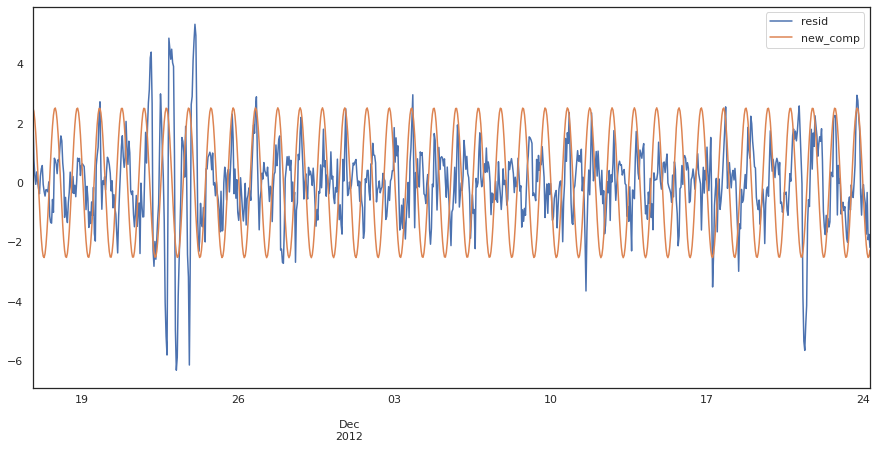

In [ ]:
resid_2.iloc[-1000:-100].plot(figsize=(15, 7))

Okay, it's not perfect, but I haven't got enough time to figure out it better

## Fourier trend decomposition 

Now let's check the trend component that we extracted in the first step

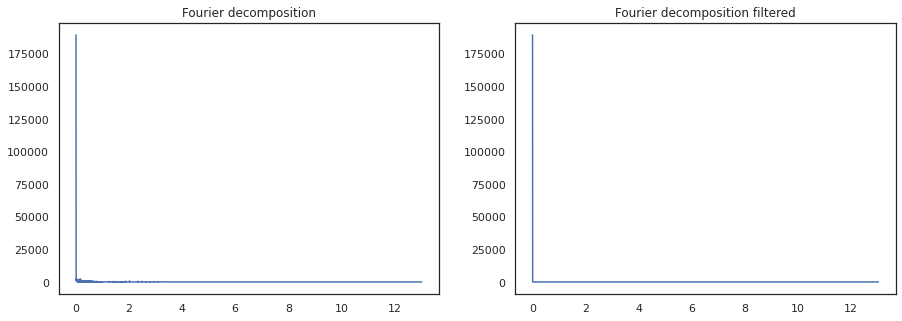

In [ ]:
N = len(trend_1["trend"].values.reshape(1,-1)[0])
DURATION = 2*12*4*7
SAMPLE_RATE = N / DURATION

yf = rfft(trend_1["trend"].values.reshape(1,-1)[0])
yf = np.abs(yf)
xf = rfftfreq(N, 1 / SAMPLE_RATE)
y_new = yf.copy()
y_new[y_new<15000] = 0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(xf, yf)
ax2.plot(xf, y_new)
ax1.set_title("Fourier decomposition")
ax2.set_title("Fourier decomposition filtered")
plt.show()

In [ ]:
new_sig = irfft(y_new)
list_ = list(new_sig[4400:4400*3])
list_ = list_*2
trend_1["seasonal"] = list_[40:-40]
trend_1["new_trend"] = trend_1["trend"] - trend_1["seasonal"]

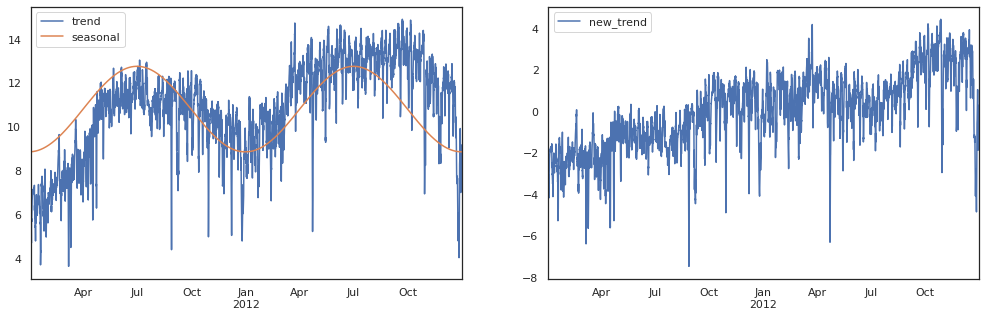

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
trend_1.loc[:, ["trend", "seasonal"]].plot(ax=ax1)
trend_1[["new_trend"]].plot(ax=ax2)
plt.show()

In [ ]:
trend_1.drop(columns=["trend"], inplace=True)

As you can see, trend component have had an intra-year pattern. And we have extracted it.

# Endog Model

Now we are ready to predict trend, unite seasonal fluctuations and make a prediction

## Predictions

In [ ]:
resid_2.dropna(inplace=True)

In [ ]:
endog_features = pd.merge(resid_2.loc[:, "new_comp"], seasonal_2, left_index=True, right_index=True, how="left")
endog_features = pd.merge(endog_features, seasonal_1, left_index=True, right_index=True, how="left")
endog_features = pd.merge(endog_features, trend_1, left_index=True, right_index=True, how="left")

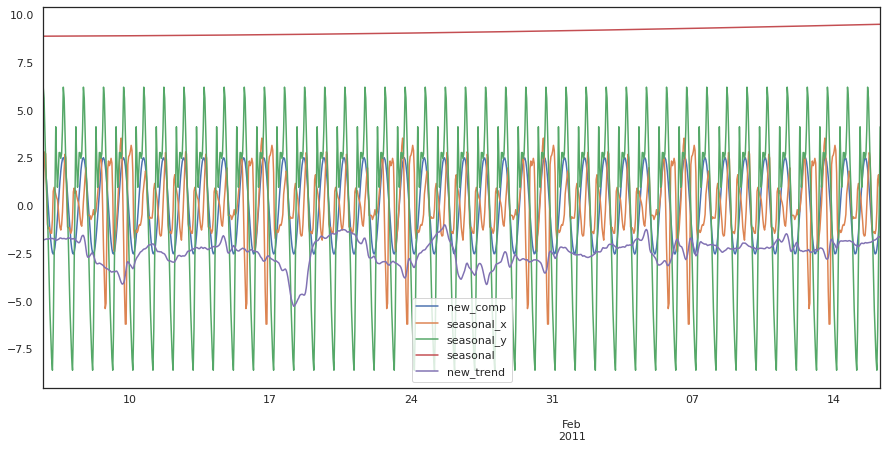

In [ ]:
endog_features.iloc[:1000].plot(figsize=(15, 7))
plt.show()

In [ ]:
X_train = endog_features["new_trend"].reset_index(drop=True).dropna()
X_train_ind = np.array(X_train.index)
y_train = X_train.values

In [ ]:
p = np.polyfit(X_train_ind, y_train, 2)
trend_pred = np.polyval(p, X_train_ind)

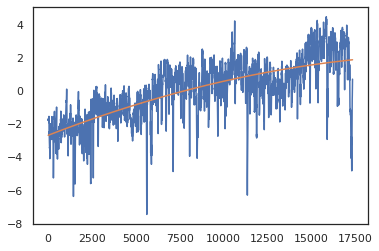

In [ ]:
endog_features["new_trend"].reset_index(drop=True).plot()
plt.plot(trend_pred)
plt.show()

In [ ]:
pred = trend_pred + endog_features["seasonal_x"].values + endog_features["seasonal_y"].values + endog_features["seasonal"].values
endog_features["pred"] = pred

In [ ]:
y_data["pred"] = endog_features["pred"]

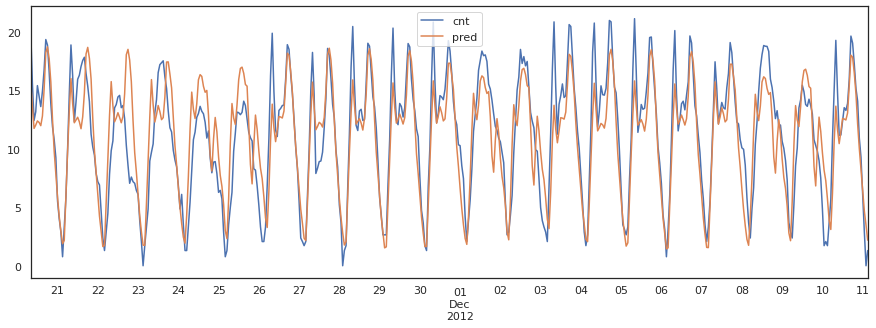

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize=(15, 5))
y_data[-1000:-500].plot(ax=ax1)
plt.show()

In [ ]:
# y_train
y_data['pred'] = invboxcox(y_data.dropna()['pred'], lmbda)
y_data['cnt'] = invboxcox(y_data.dropna()['cnt'], lmbda)

In [ ]:
mae_endog = mean_absolute_error(y_data.dropna()["pred"], y_data.dropna()["cnt"])

In [ ]:
print(f"mae train: {mae_endog}")

mae train: 62.14898845762617


I do not have  enough time to build a prediction for the test sample, but i don't think, that it will be far from the training score

So this approach was naive and simple, but it gave us pretty good quality on the training set

## Residual analysis

In [ ]:
y_data["resids"] = y_data['cnt']- y_data['pred']
y_data.dropna(inplace=True)

Fitting of residuals by Laplace distribution: fitted mean = 2.211, fitted std = 62.065
Fitting of residuals by Normal distribution: fitted mean = 8.689, fitted std = 93.752


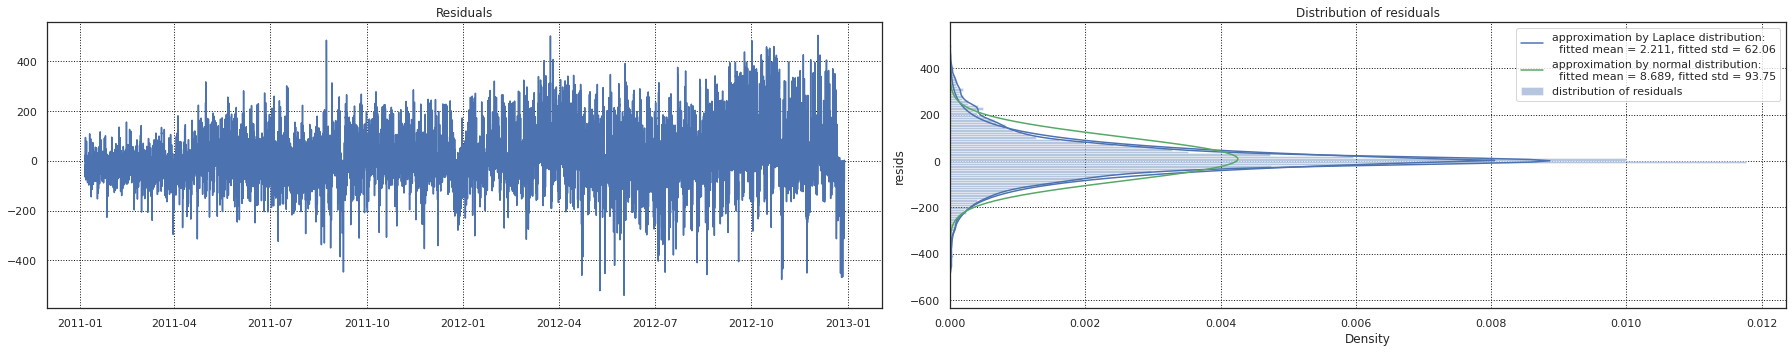

In [ ]:
resid_analysis(y_data["resids"])

The error's distribution is a little bit shifted. And MAE was an excellent choice because errors are distributed like Laplace distribution.  
 
Also, we can see heteroscedasticity here. Maybe it would be better to use multiplicative seasonal components instead of additive ones.

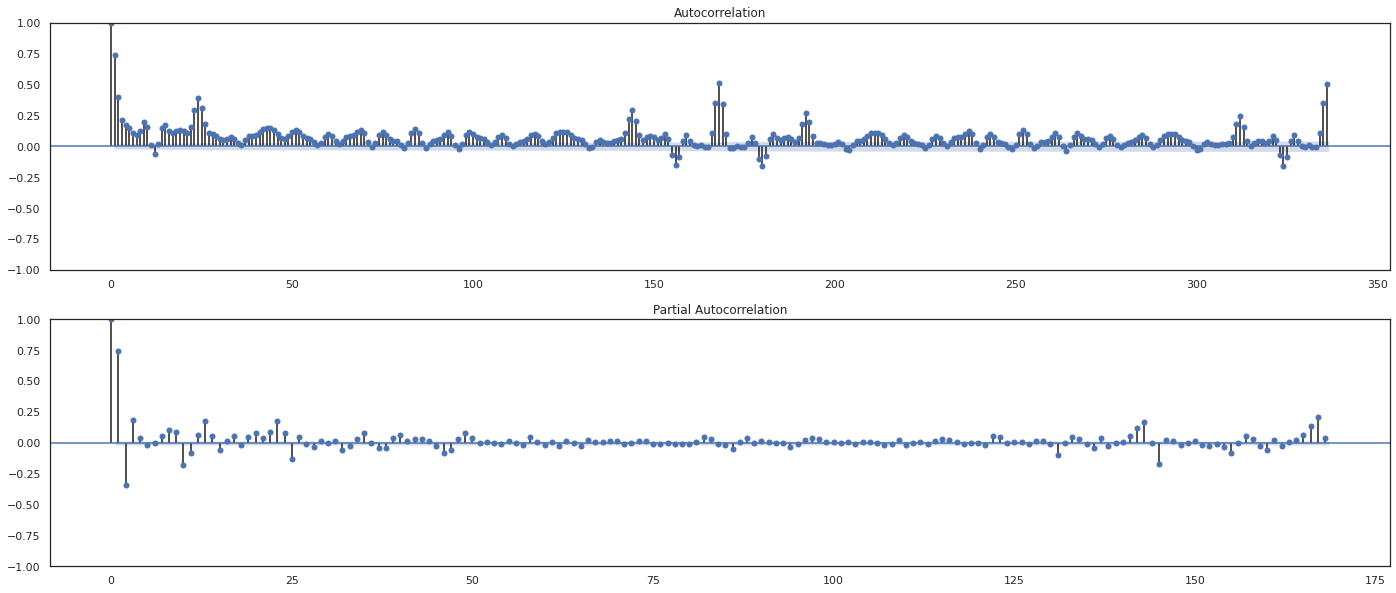

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_data["resids"].values.squeeze(), lags=24*7*2, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_data["resids"].values.squeeze(), lags=24*7, ax=ax2)

And we still haven't caught some patterns.



# SARIMA

Now we are ready to use ARIMA class models. So we have already performed some analysis. And I consider that using ARIMA is not appropriate here. So I think it is going to be better to use the SARIMA model. They are pretty similar.  
I hope you will agree with this statement and do not downgrade my score 

## Data Preparation

### the first seasonal diffs

In [ ]:
y_train, y_test = y_data.loc[:"2012-11-30"], y_data.loc["2012-11-30":]

In [ ]:
# transformer = PowerTransformer(method='yeo-johnson', standardize=True)
# y_train["cnt"] = transformer.fit_transform(y_train.dropna())
# y_test["cnt"] = transformer.transform(y_test.dropna())

So we had to do non-linear transformation here, but something was going wrong, and I skipped that step. I spent too much time on advanced regression, and now I don't have enough time for that task

In [ ]:
y_train["cnt_24"] = y_train["cnt"].diff(24)

Fitting of residuals by Laplace distribution: fitted mean = 0.124, fitted std = 1.794
Fitting of residuals by Normal distribution: fitted mean = 0.042, fitted std = 2.577


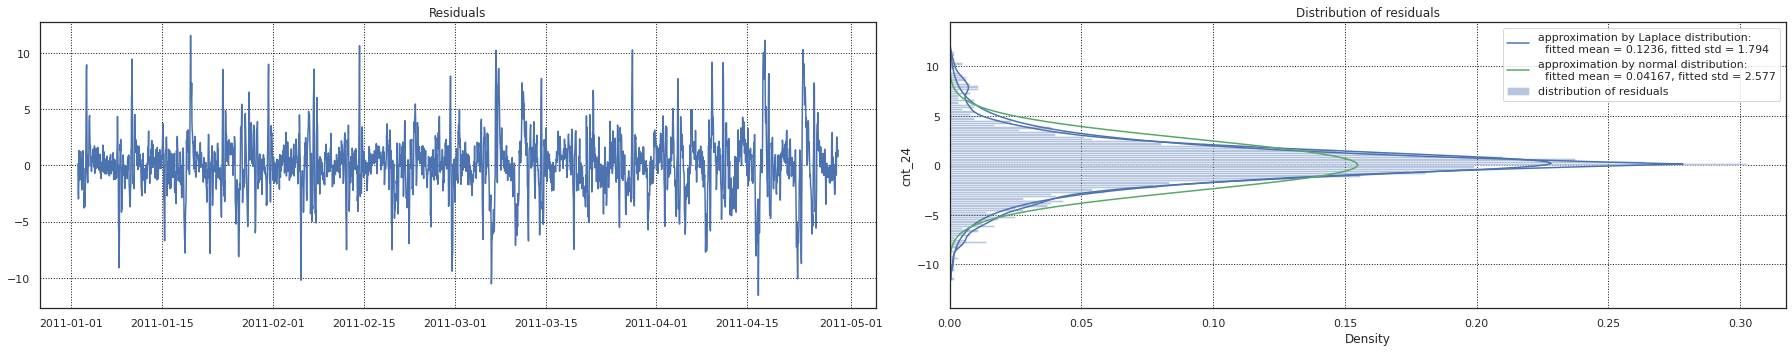

In [ ]:
resid_analysis(y_train.loc[:"2011-04-28", "cnt_24"].dropna())

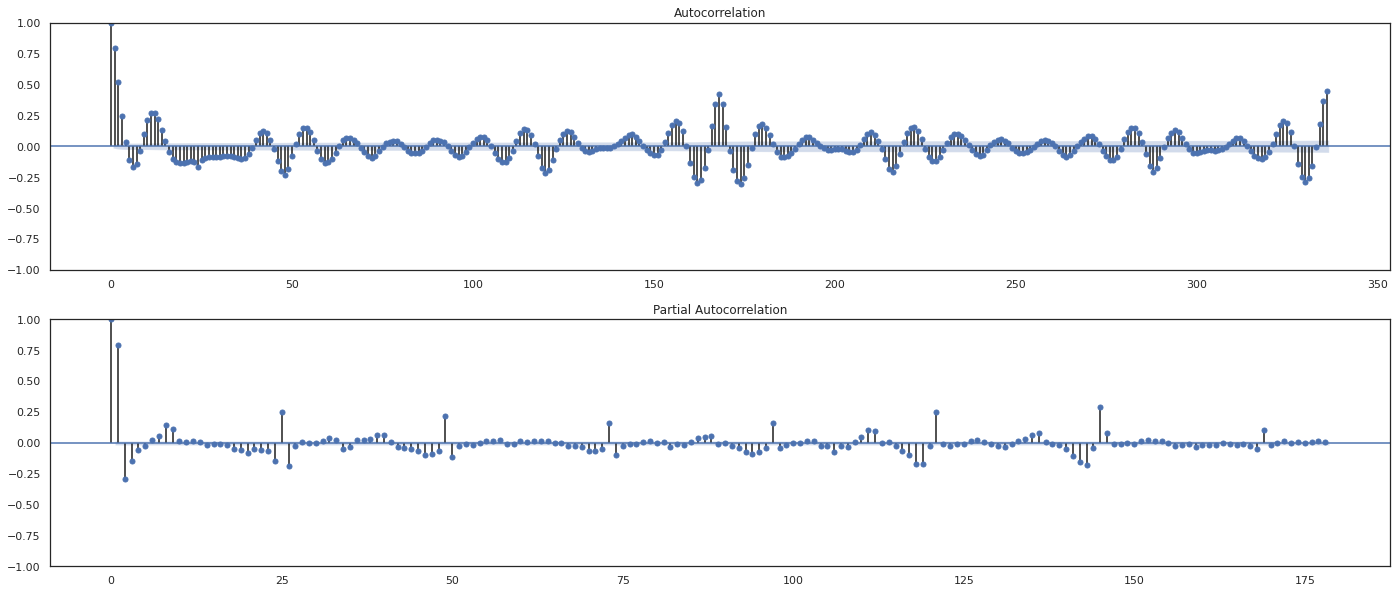

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_train["cnt_24"][24*3:].values.squeeze(), lags=24*14, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_train["cnt_24"][24*3:].values.squeeze(), lags=24*7+10, ax=ax2)

In [ ]:
stationarity_tests(y_train["cnt_24"].dropna())

alpha = 0.05

Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -22.914943701094444
p-value: 0.0
The process is stationary.

Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.008138172221724888
p-value = 0.1
The process is stationary.



As we can see, tests say that series is stationary, but ACF give us information that values of sequences still depends on the time. Resids contain a seasonal component with a period = 24*7. It means that except for intraday seasonality, we've got a weekly one.

### the second seasonal diffs

In [ ]:
y_train["cnt_24_168"] = y_train["cnt_24"].diff(24*7)

Fitting of residuals by Laplace distribution: fitted mean = 0.000, fitted std = 2.082
Fitting of residuals by Normal distribution: fitted mean = -0.003, fitted std = 3.023


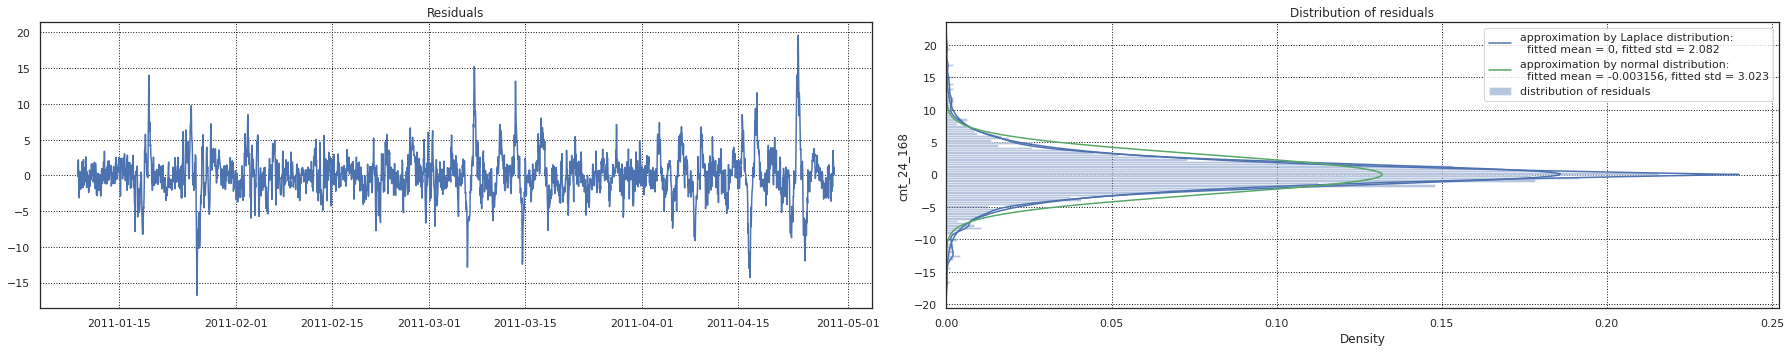

In [ ]:
resid_analysis(y_train.loc[:"2011-04-28", "cnt_24_168"].dropna())

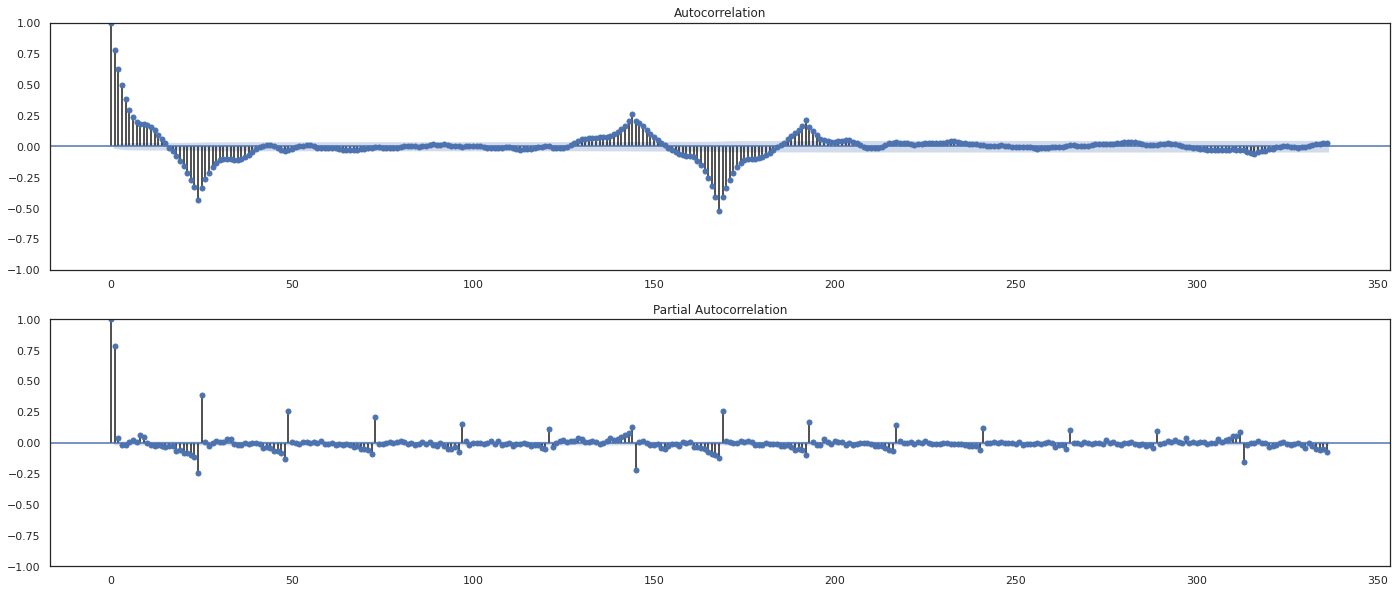

In [ ]:
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_train["cnt_24_168"][24*7+24:].values.squeeze(), lags=24*14, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_train["cnt_24_168"][24*7+24:].values.squeeze(), lags=24*14, ax=ax2)

A considerable pattern still exists in the graph, but I have no idea what to fix it. So basically we can give SARIMA model information about seasonal components

We can use at least first 5 MA components here and maybe 3 AR  
Also we have seasonal fluctuation in PACF, so we can assume that we should add Ps=24 or 25  
Also, we probably should add some patterns to the Qs component, but it's hard for me to figure out how we should catch a seasonal patterns in the ACF function

I faced a problem here; I don't have enough memory to fit models with Ps and Qs components with such massive lag. So I will use the previous series with just ps and qs components and with the first seasonal diffs with a period = 24

In [ ]:
stationarity_tests(y_train["cnt_24_168"].dropna())

alpha = 0.05

Augmented Dickey–Fuller (Null hypothesis - The process is non-stationary): 
ADF Statistic: -25.221228282665706
p-value: 0.0
The process is stationary.

Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (Null hypothesis - The process is stationary):
KPSS Statistic = 0.0033988065183667682
p-value = 0.1
The process is stationary.



## Model fitting

In [ ]:
ps = 5
d = 0
qs = 5
Ps = [0, 25]
D = 1
Qs = 0

# parameters = product(ps, qs)
# parameters_list = list(parameters)
# len(parameters_list)

In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(Ps[:1]):
    try:
        model=sm.tsa.statespace.SARIMAX(y_train.cnt, order=(ps, d, qs), 
                                        seasonal_order=(0, D, Qs, 24)).fit(disp=-1)
    # show broken params
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save best model, aic, params
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters            aic
0           0  187923.863798


### Model Summary

In [ ]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                 cnt   No. Observations:                16800
Model:             SARIMAX(5, 0, 5)x(0, 1, [], 24)   Log Likelihood              -93950.932
Date:                             Tue, 05 Oct 2021   AIC                         187923.864
Time:                                     16:28:01   BIC                         188008.869
Sample:                                 01-01-2011   HQIC                        187951.913
                                      - 11-30-2012                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9523      0.010    186.981      0.000       1.932       1.973
ar.L2         -2.5934      

### Resid analysis

Fitting of residuals by Laplace distribution: fitted mean = -0.080, fitted std = 42.292
Fitting of residuals by Normal distribution: fitted mean = 0.140, fitted std = 65.383


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1689: FutureWarning: The `vertical` parameter is deprecated and will be removed in a future version. Assign the data to the `y` variable instead.
  warnings.warn(msg, FutureWarning)


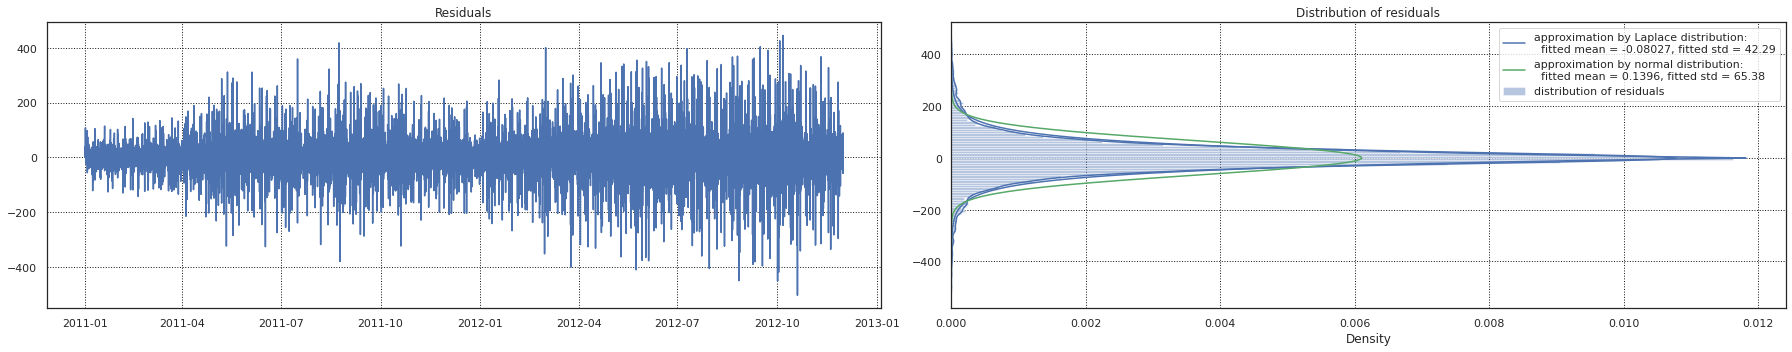

In [ ]:
resid_analysis(best_model.resid.dropna())

Критерий Стьюдента: p=0.870739
Критерий Дики-Фуллера: p=0.000000


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


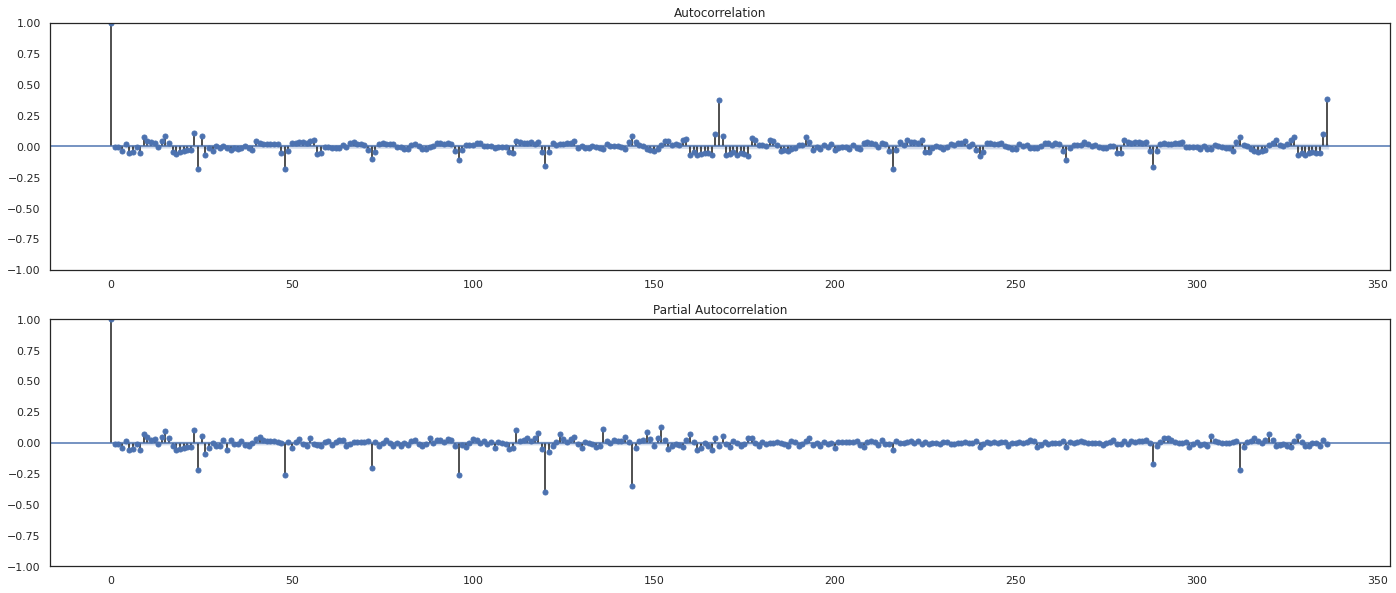

In [ ]:
print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[24:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[24:])[1])
fig = plt.figure(figsize=(24,10))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=24*14, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(best_model.resid.values.squeeze(), lags=24*14, ax=ax2)

### Predictions

In [ ]:
# y_train.loc[:, 'cnt'] = transformer.inverse_transform(y_train.loc[:, ['cnt']])
# y_test.loc[:, "cnt"] = transformer.inverse_transform(y_test.loc[:, ["cnt"]])

In [ ]:
results_tr = best_model.fittedvalues[1:]
results_tt = best_model.predict(start=y_test.index[0], end=y_test.index[-1])

In [ ]:
y_train = y_train.iloc[1:]
y_train.loc[:, "model"] = results_tr.values
y_test.loc[:, "model"] = results_tt.values

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


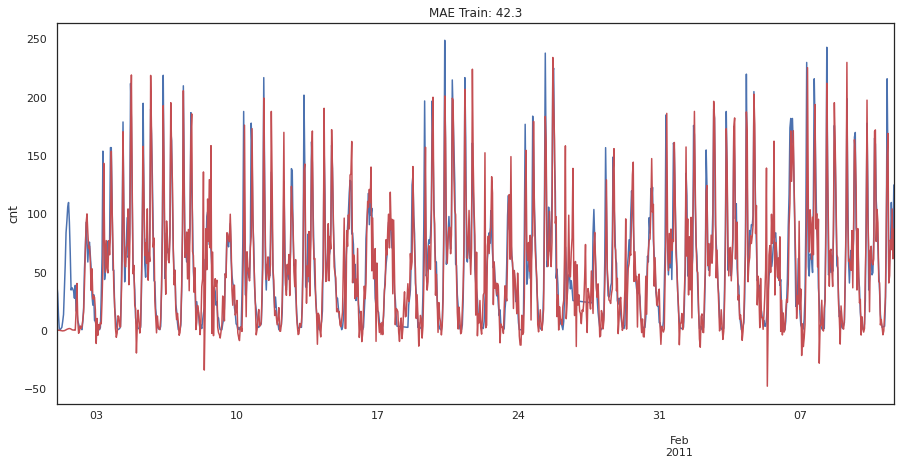

In [ ]:
plt.figure(figsize=(15,7))
y_train.cnt[:1000].plot()
y_train.model[:1000].plot(color='r')
plt.ylabel('cnt')
plt.title(f"MAE Train: {mean_absolute_error(y_train.dropna()['model'], y_train.dropna()['cnt']):0.03}")
plt.show()

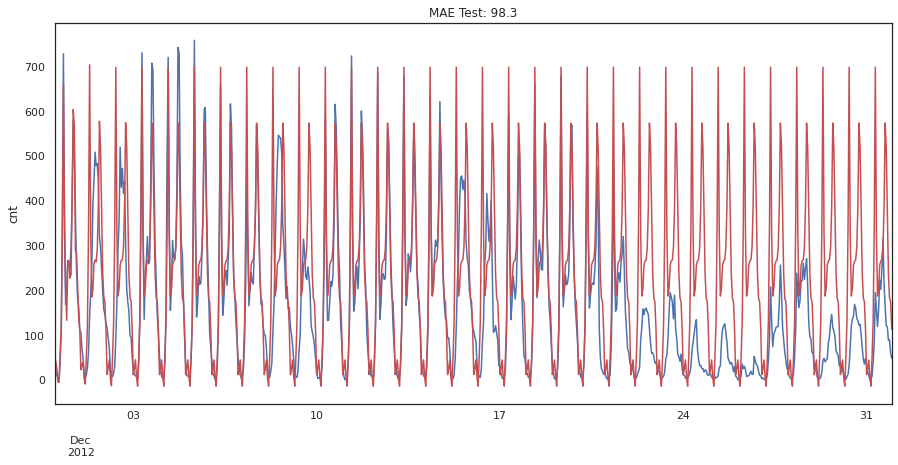

In [ ]:
plt.figure(figsize=(15,7))
y_test.cnt.plot()
y_test.model.plot(color='r')
plt.ylabel('cnt')
plt.title(f"MAE Test: {mean_absolute_error(y_test.dropna()['model'], y_test.dropna()['cnt']):0.03}")
plt.show()

The error is acceptable, but it could be better

### Now let's add exog features

In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(Ps[:1]):
    try:
        model=sm.tsa.statespace.SARIMAX(y_train.cnt, order=(ps, d, qs), 
                                        seasonal_order=(0, D, Qs, 24), 
                                        exog=x_train).fit(disp=-1)
    # show broken params
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # save best model, aic, params
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

Time is up, this is where I end